<a href="https://colab.research.google.com/github/Kabir2919/Deep-Fake-Audio-Recognition/blob/main/deepfake_detection_final_39mfcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install numpy
!pip install librosa
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
!pip install tqdm
!pip install xgboost
!pip install scikit-learn
!pip install catboost

In [ ]:
!pip install numpy==1.26.4

In [ ]:
!pip install --upgrade --force-reinstall tensorflow catboost numba

  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numba-0.61.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached absl_py-2.2.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.m

In [ ]:
import pandas as pd
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)

from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_file='/content/drive/MyDrive/extracted_features2_39mfcc.csv'

In [ ]:
data_file

'/content/drive/MyDrive/extracted_features2_39mfcc.csv'

In [ ]:
audio_data = pd.read_csv(data_file)

In [ ]:
label_encoder = LabelEncoder()
audio_data['LABEL'] = label_encoder.fit_transform(audio_data['LABEL'])

audio_data

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,LABEL
0,-0.778782,-1.139359,-0.837353,-0.990933,-0.795138,-0.734372,-0.852318,-1.058199,0.332959,-1.021614,...,1.069422,1.038762,0.248218,-0.116762,0.067556,0.536274,0.901263,0.732586,-0.234473,1
1,1.041610,1.705655,0.477109,0.947152,0.798342,-0.196662,1.241862,1.112664,-0.063222,-0.440030,...,0.994159,0.787101,1.292655,1.038385,0.113320,-0.995524,-1.189688,-1.011113,0.056230,1
2,1.071299,2.117925,0.336604,0.704873,0.233265,-0.125598,1.895218,2.000760,0.784136,1.560578,...,-0.442427,-1.406607,-1.297840,-1.334197,-1.087129,-1.363274,-0.817445,-0.902995,-0.474200,1
3,1.132479,-0.148574,1.006260,1.222916,1.193680,0.197659,0.293437,0.144794,-0.693282,-0.232284,...,1.075960,0.707985,-0.194628,-0.670298,-0.834935,-0.294246,-0.450006,-0.426574,-0.663415,1
4,0.954295,0.574590,1.213798,1.223303,1.264584,1.192558,0.465974,0.635860,-0.841225,0.590859,...,-0.010083,1.590228,0.801448,1.303486,0.657814,0.239652,0.371628,-0.756551,0.149843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43155,-1.439747,-1.581141,-0.770644,-1.023866,-0.713876,-1.187777,-2.045512,-1.434041,-0.026017,-0.203519,...,0.201149,-0.103541,-0.131879,-0.066405,-0.107116,0.181385,-0.136645,0.467183,0.131204,0
43156,0.125680,0.145059,0.529473,0.351635,0.498384,0.238820,0.816845,0.676229,-1.856630,0.706005,...,0.426265,-0.068318,-0.316015,-0.777243,0.077396,0.336471,0.828133,-0.358598,-0.447035,0
43157,1.081361,0.628269,-0.134076,0.057354,-0.202897,-0.135415,0.063184,0.216119,0.796735,1.150547,...,-0.279545,-0.001503,-0.647209,-0.272983,-0.540652,-0.415377,-0.111025,-0.713141,-0.192235,0
43158,0.205507,-0.553373,-0.404967,0.176031,-0.410619,-0.203057,-0.208330,-0.105820,0.871441,-0.882514,...,0.831038,1.079590,0.705017,0.597346,0.455356,0.402653,0.893342,1.279328,0.715699,0


In [ ]:
y = audio_data['LABEL']
X = audio_data.drop('LABEL', axis = 1)

In [ ]:
real_df = audio_data[audio_data['LABEL'] == 1]
fake_df = audio_data[audio_data['LABEL'] == 0]

In [ ]:
# Set n to the minimum available size
n_samples = min(len(real_df), len(fake_df))  # Ensures no sampling errors

# Perform sampling
real_df_downsampled = real_df.sample(n=n_samples, random_state=42)
fake_df_downsampled = fake_df.sample(n=n_samples, random_state=42)

print("Downsampled Real DataFrame Size:", len(real_df_downsampled))
print("Downsampled Fake DataFrame Size:", len(fake_df_downsampled))

# Combine the datasets and shuffle
balanced_audio_data = pd.concat([real_df_downsampled, fake_df_downsampled]).sample(frac=1, random_state=42)

# Split features and labels
X = balanced_audio_data.drop(columns=['LABEL'])
y = balanced_audio_data['LABEL']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, shuffle=True, random_state=42)

# Print class distribution
print(y_train.value_counts(), y_test.value_counts())

Downsampled Real DataFrame Size: 12493
Downsampled Fake DataFrame Size: 12493
LABEL
1    9994
0    9994
Name: count, dtype: int64 LABEL
0    2499
1    2499
Name: count, dtype: int64


In [ ]:
real_df_downsampled

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,LABEL
2884,0.693092,1.006137,1.254979,1.521907,1.284574,1.800656,1.376659,-0.082854,1.032068,-1.907273,...,-0.887661,-0.568413,-0.828828,0.018058,-0.766030,0.926402,-0.582320,-0.285033,-0.792534,1
5460,-0.667006,-0.877096,-0.476519,-0.162301,-0.199561,-0.234017,-0.900081,-1.470866,1.222150,-1.264489,...,0.504373,0.674658,-0.261336,-0.079143,-1.022972,-0.138555,-0.213575,-0.122829,-0.970558,1
7959,1.564114,-0.154554,1.232935,1.187205,1.300858,1.918138,0.961308,0.054372,-1.221249,0.217399,...,-0.882086,-0.160485,-0.027702,0.595191,-0.489806,-0.940357,0.304111,0.893052,1.608750,1
9246,-0.185059,0.039808,-0.285085,-0.021082,-0.167681,-0.313163,-0.175680,-0.842973,1.947914,-0.984660,...,-1.055508,-0.848468,-1.331504,-0.628749,-1.052528,-0.813104,-1.088375,-0.533810,-1.020999,1
11228,0.826876,-0.667167,1.119088,1.260329,1.424172,1.422239,0.233548,-0.838758,0.337904,-0.429185,...,0.704333,-0.047831,-1.158983,-0.830258,-0.375258,1.403928,1.429918,1.118277,-0.248459,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,-0.297860,-0.924477,-0.107283,0.050431,0.049821,0.605303,-0.783403,-1.404014,2.086250,-1.520525,...,-0.844343,-0.963085,-1.115924,-0.053128,-0.867321,0.004642,-0.159268,0.022441,0.111860,1
5191,-0.216852,0.516691,0.568225,0.474891,0.719528,1.013276,0.746469,-0.922770,-0.067429,-1.037385,...,1.245286,1.299884,0.149972,-0.125806,-1.539100,-0.218405,0.089832,-0.146499,-1.281652,1
5390,-0.896176,-1.113365,-1.381344,-1.265879,-1.358857,-0.927039,-1.553305,-0.668751,0.694055,-1.549685,...,-0.382900,-0.621314,-0.811934,-0.329590,-0.746410,0.436583,0.331857,0.699882,0.926326,1
860,0.307517,-0.817645,-0.573629,-0.066606,-0.150103,-1.243530,-1.316949,-0.367193,0.520210,-0.120013,...,-0.500611,-0.314709,-0.768353,-0.655056,-0.728039,-0.776446,-0.730989,-0.747495,-0.529303,1


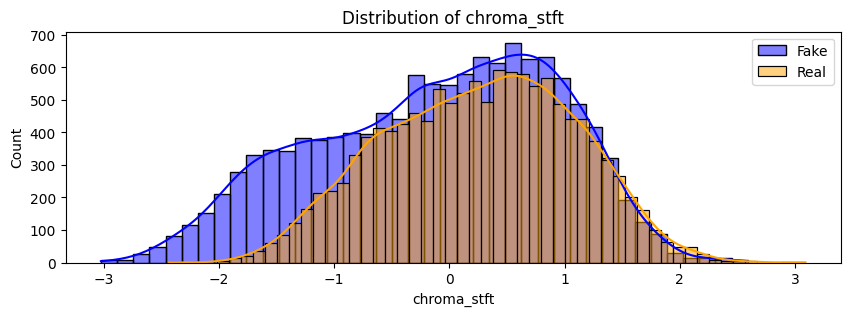

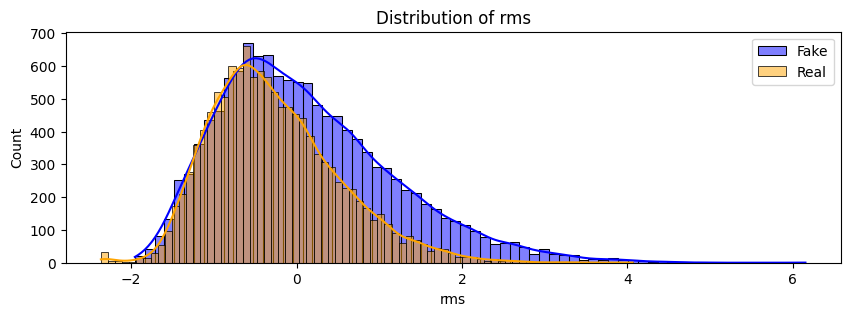

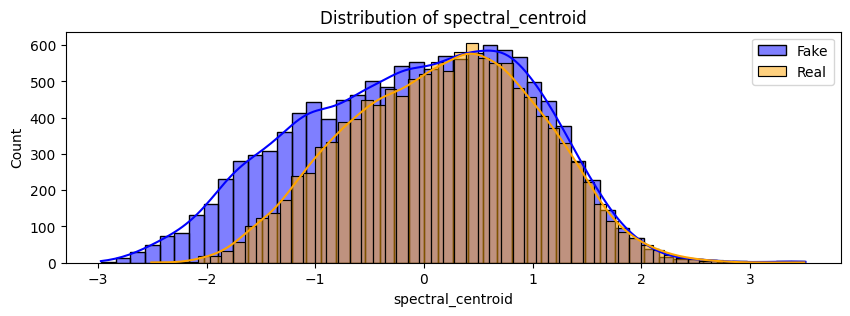

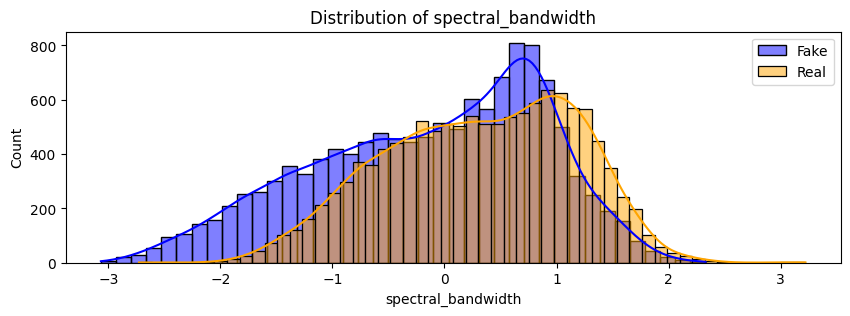

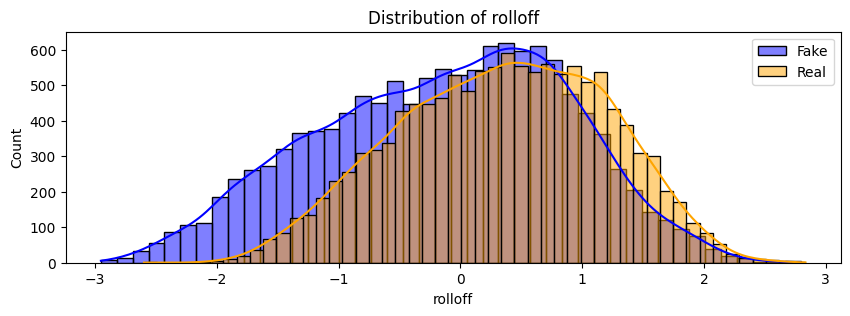

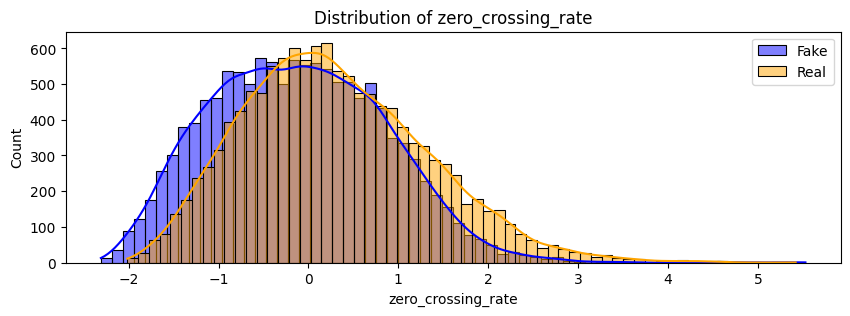

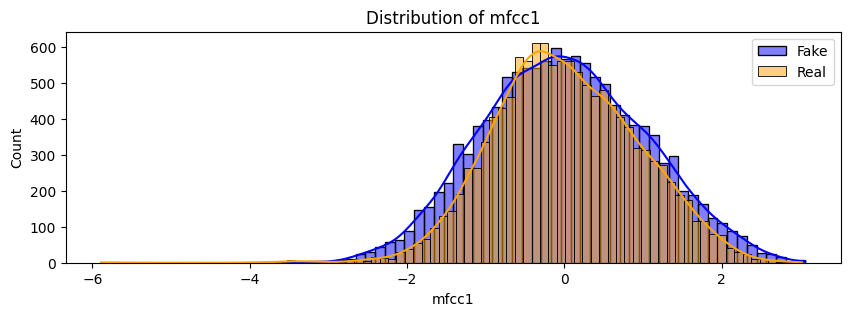

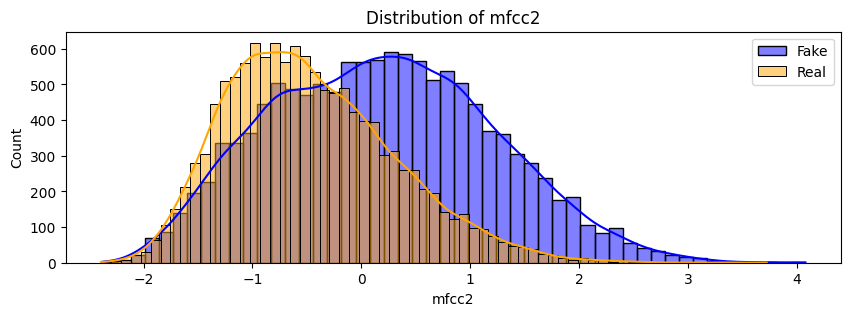

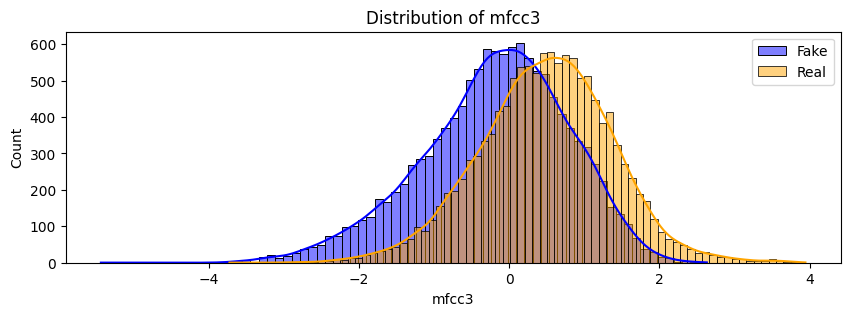

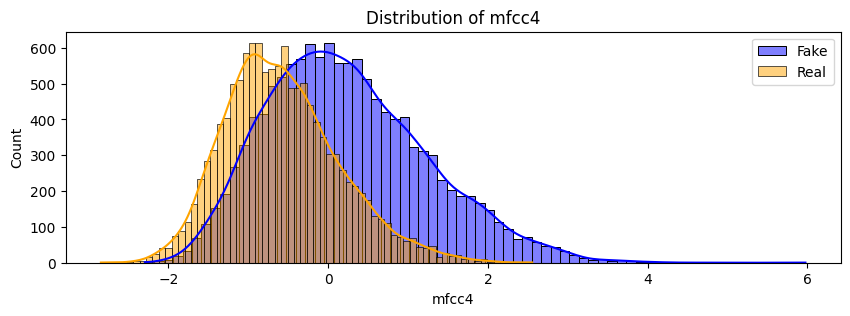

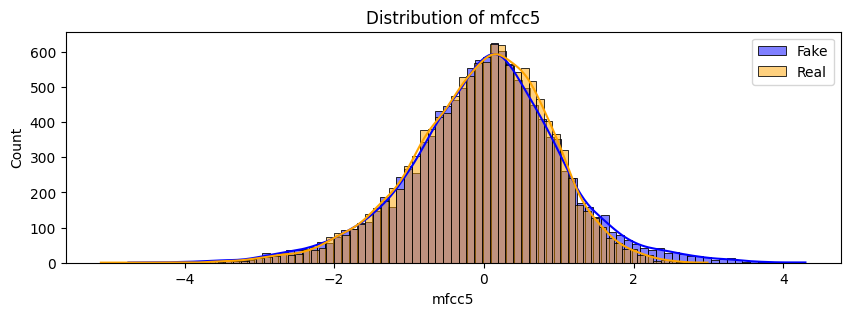

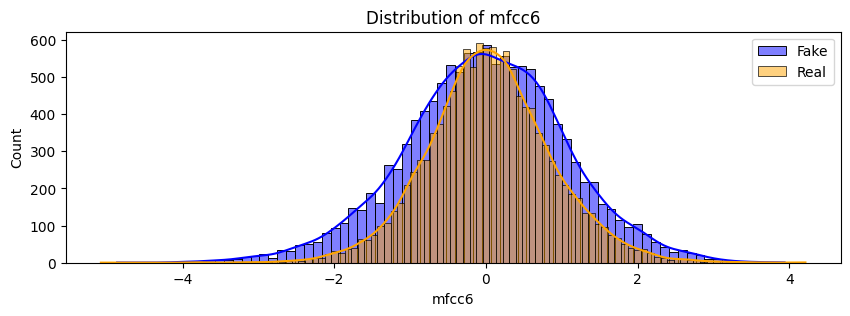

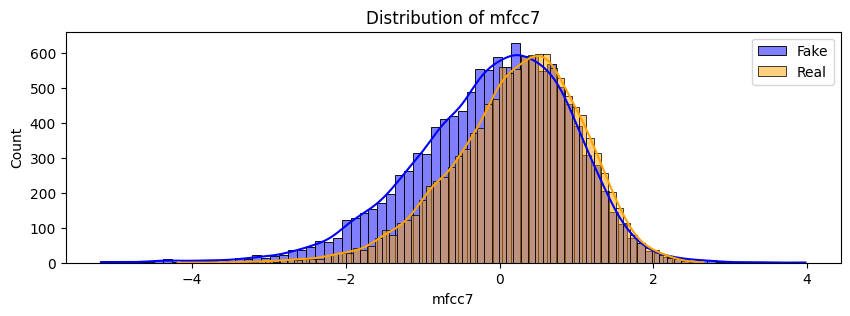

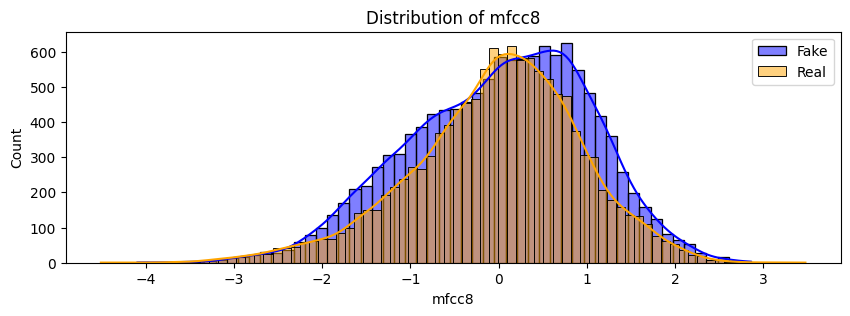

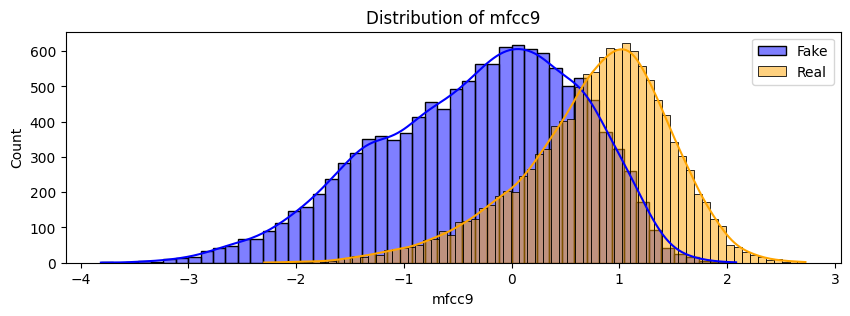

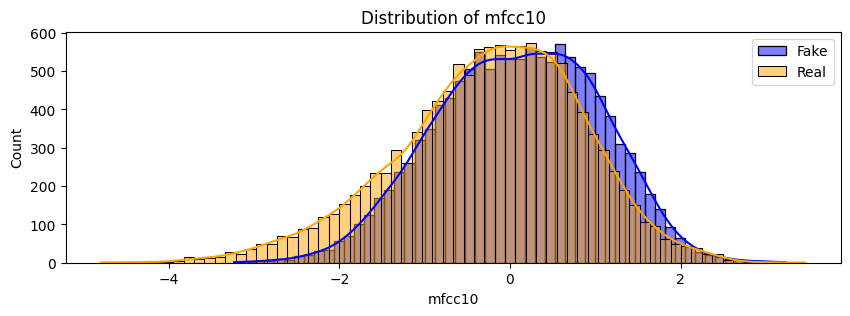

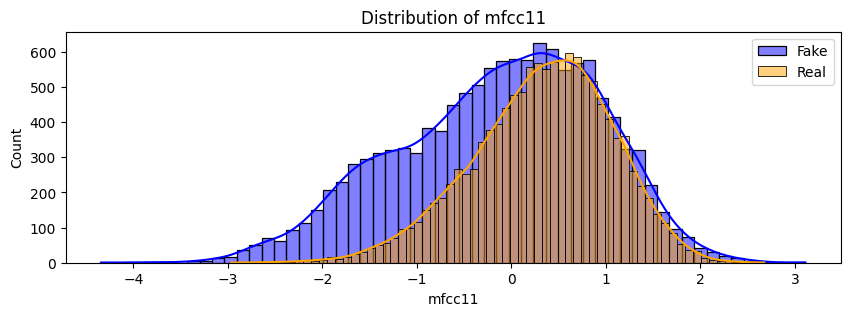

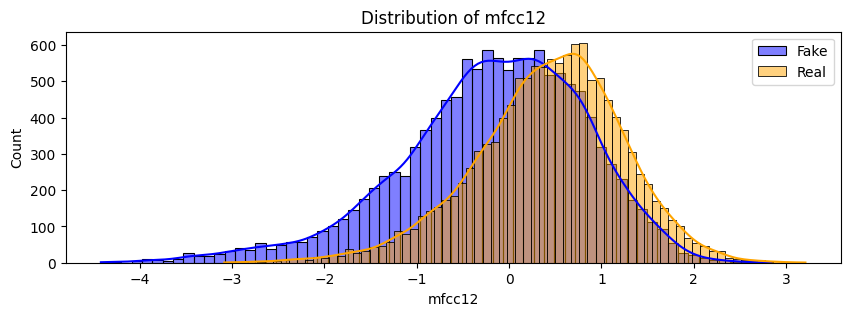

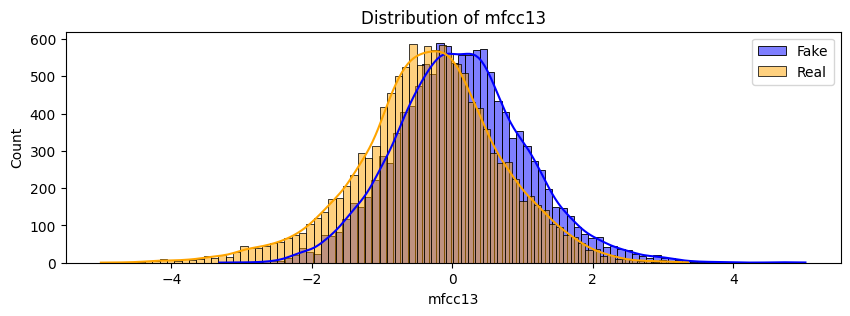

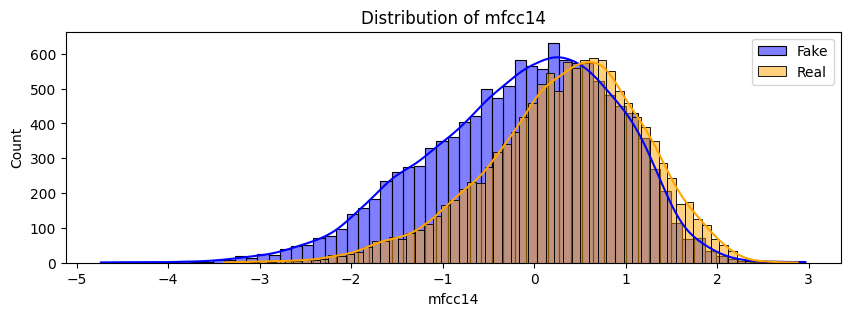

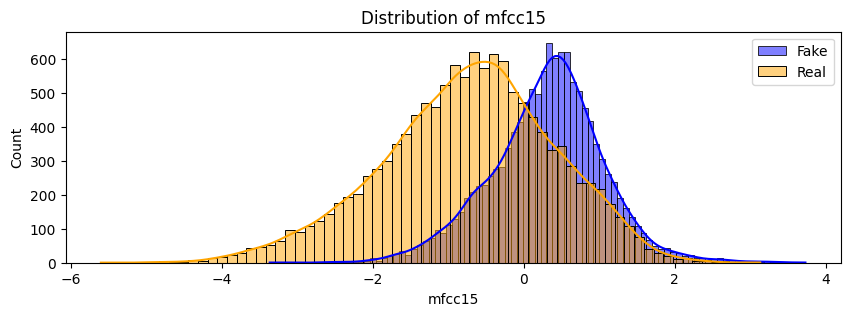

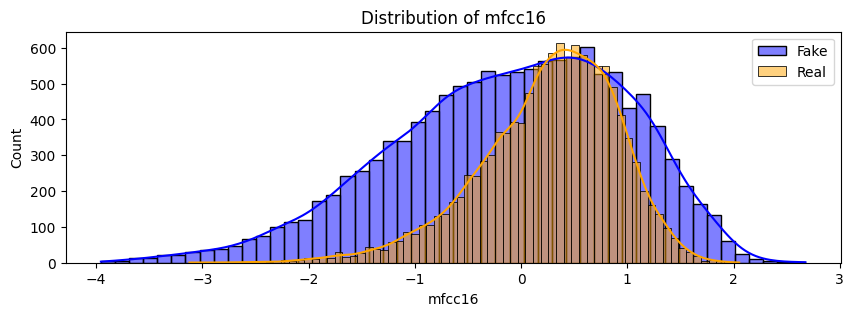

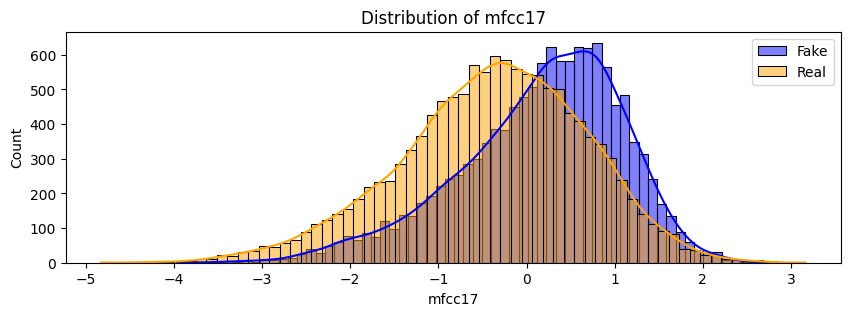

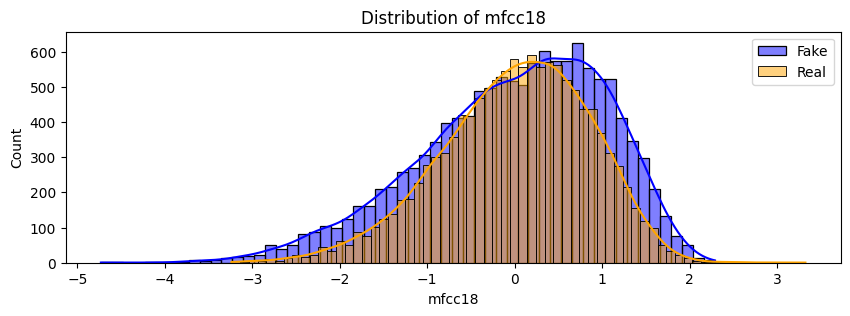

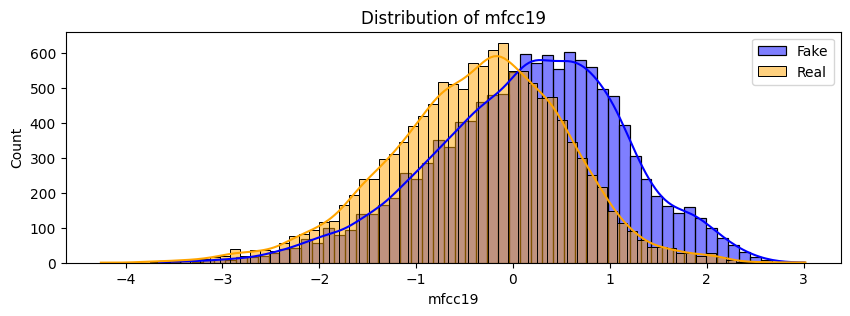

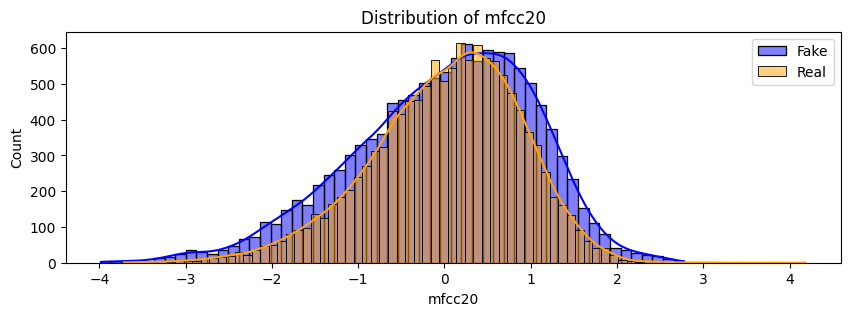

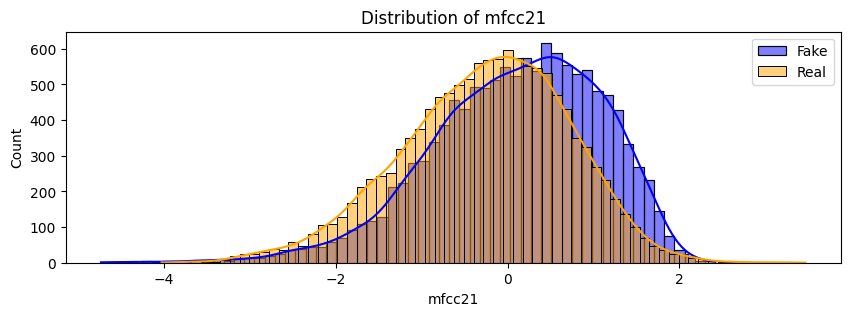

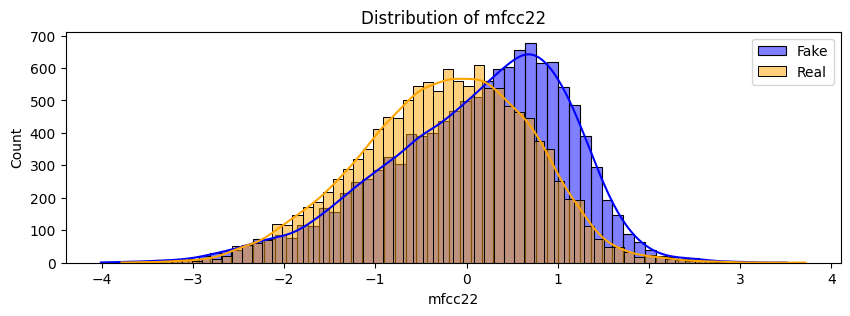

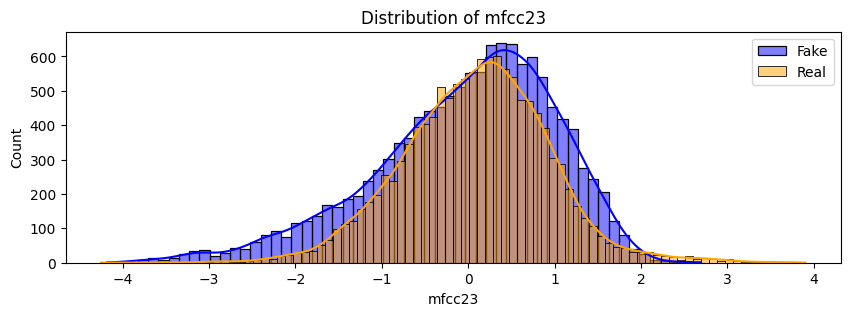

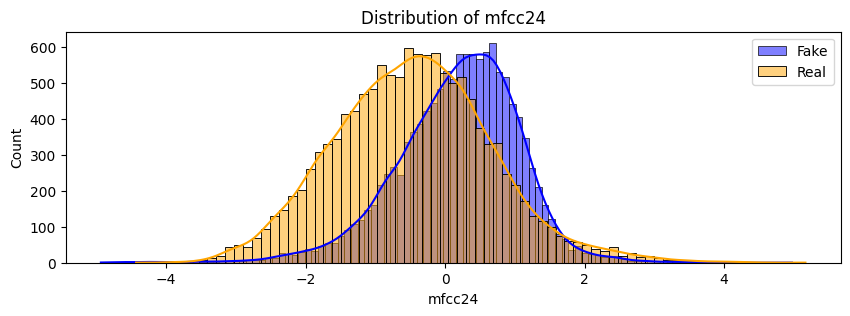

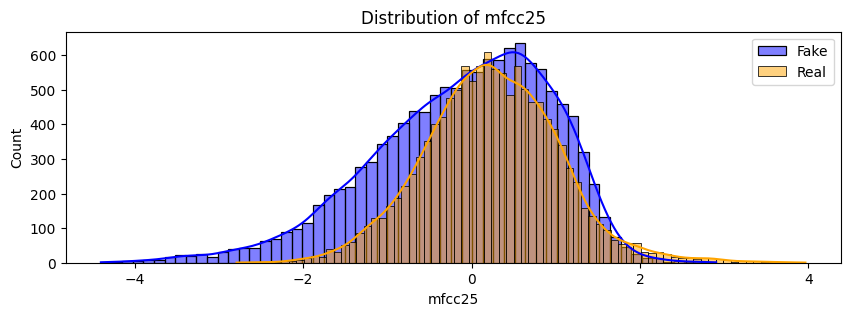

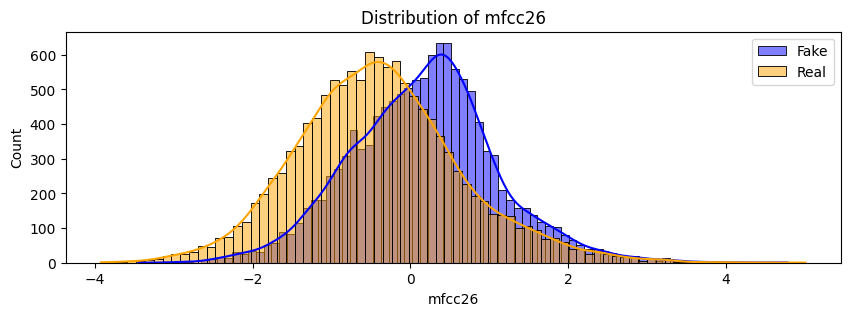

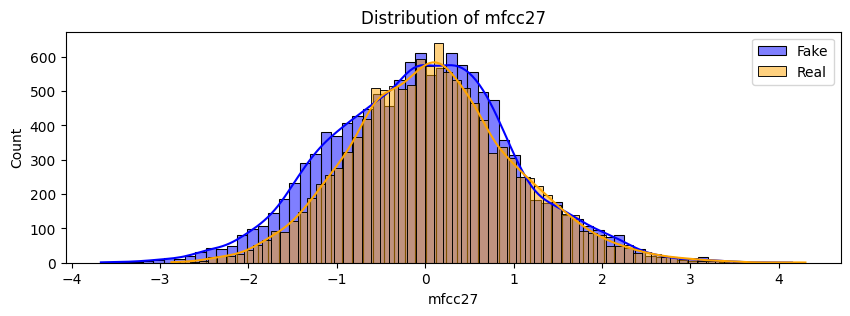

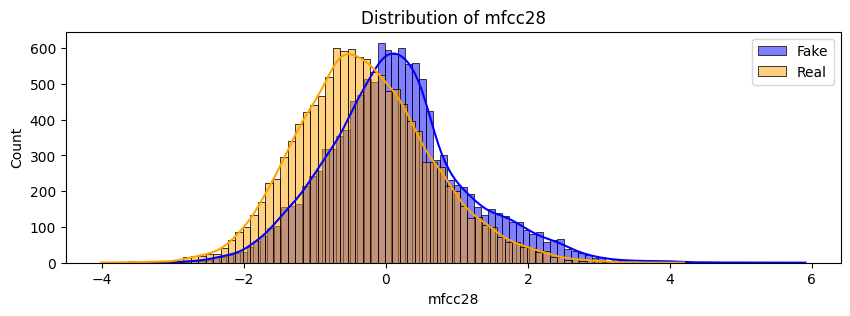

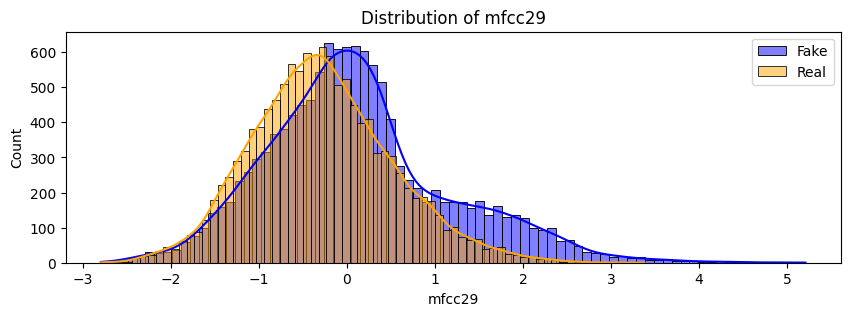

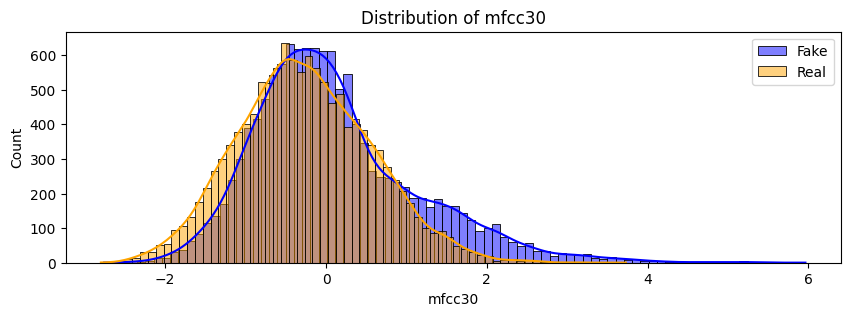

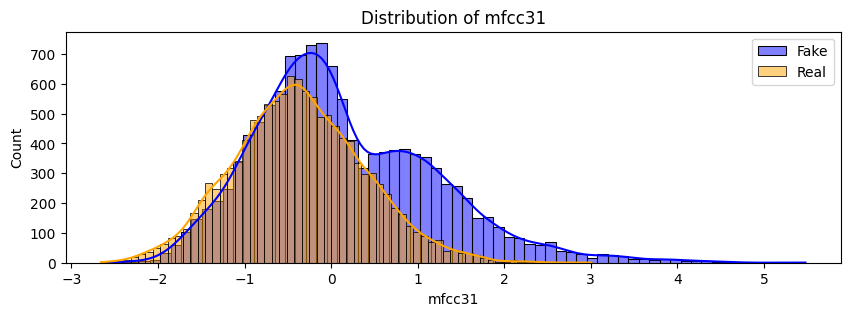

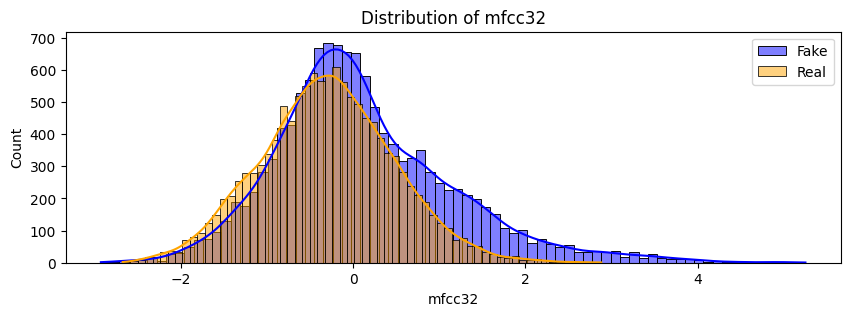

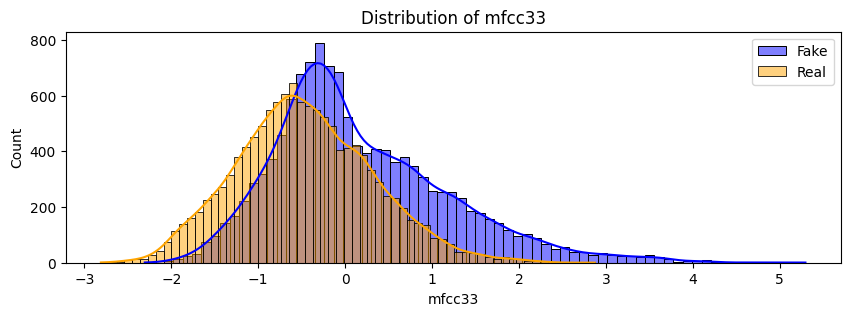

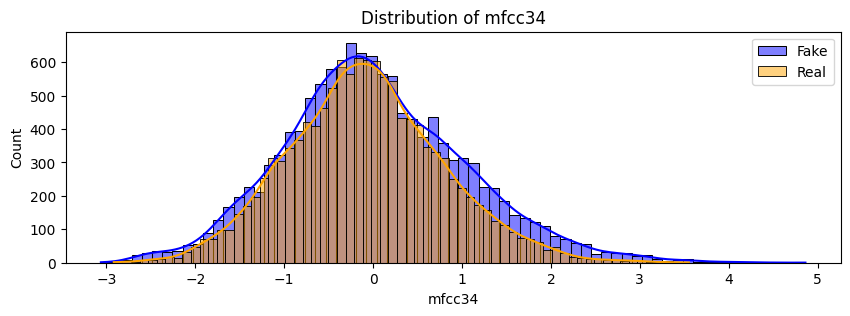

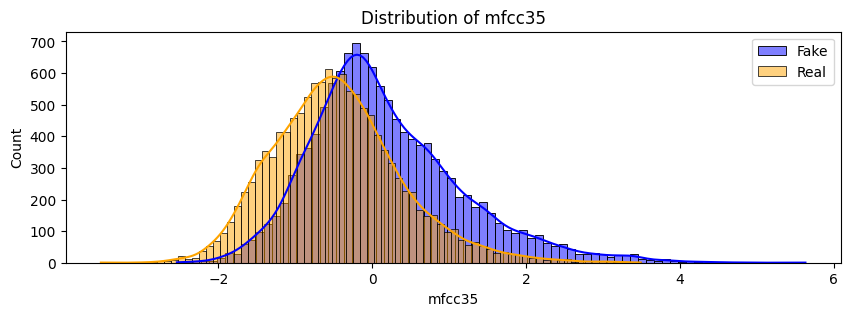

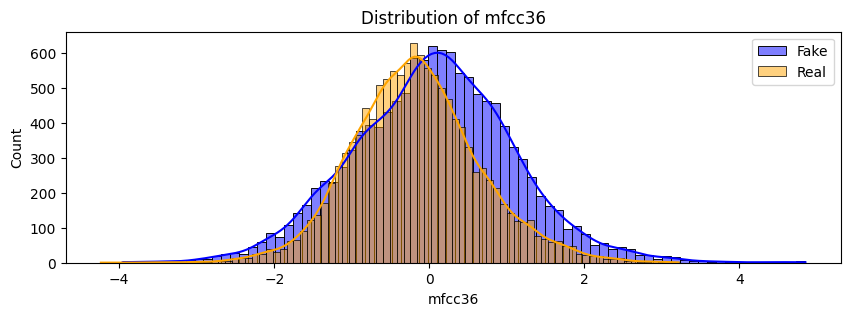

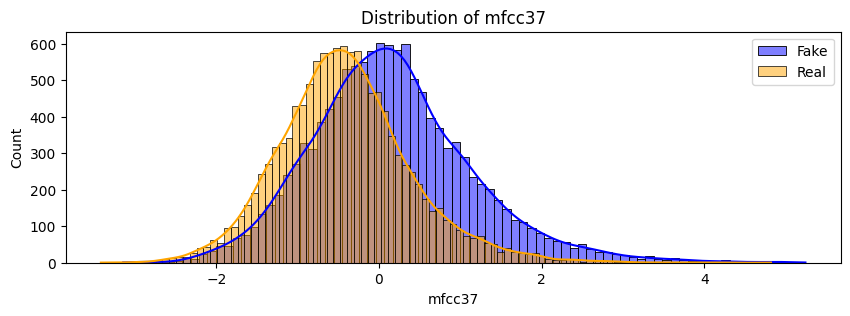

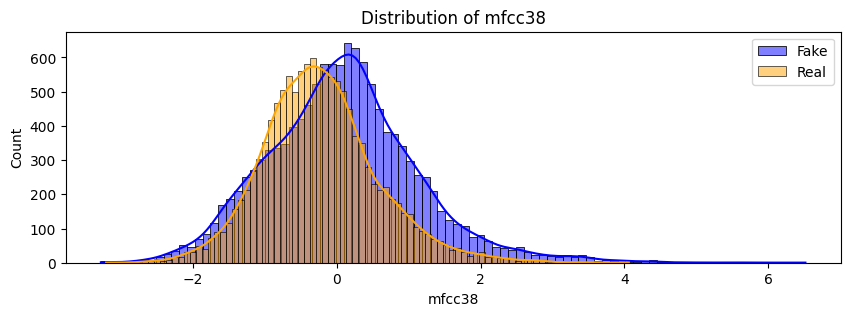

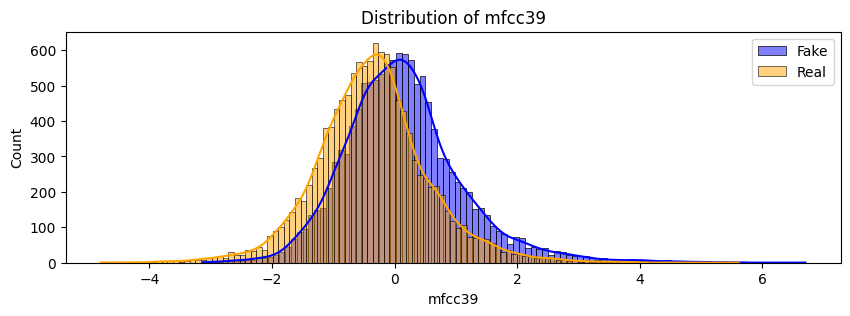

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

for column in X:
    plt.figure(figsize=(10, 3))
    sns.histplot(fake_df_downsampled[column], kde=True, label='Fake', color='blue')
    sns.histplot(real_df_downsampled[column], kde=True, label='Real', color='orange')

    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()


In [ ]:
# warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# for column in X:
#     plt.figure(figsize=(10, 3))
#     sns.histplot(audio_data[audio_data['LABEL'] == 0][column], kde=True, label='Fake', color='blue')
#     sns.histplot(audio_data[audio_data['LABEL'] == 1][column], kde=True, label='Real', color='orange')
#     plt.title(f'Distribution of {column}')
#     plt.legend()
#     plt.show()

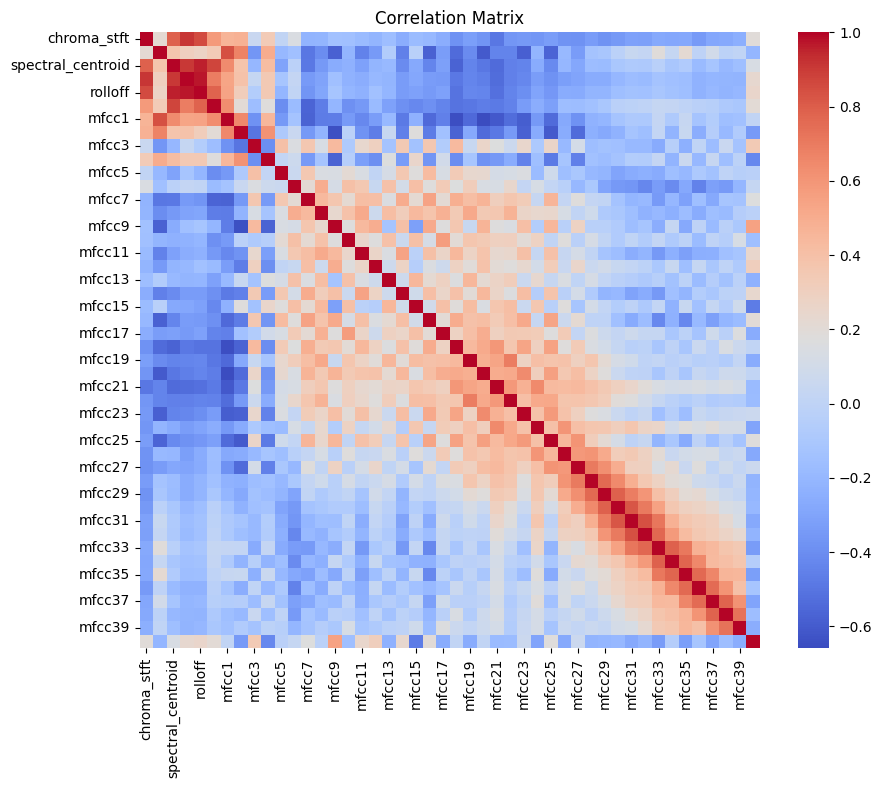

In [ ]:
import seaborn as sns

correlation_matrix = balanced_audio_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
X_train

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc30,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39
147,0.913369,-0.748020,0.636107,1.057554,1.134825,-0.015624,-0.861278,0.037543,0.714435,0.266479,...,-0.476187,-0.220147,-0.094273,-0.530513,-0.383866,-0.284178,-0.814985,-0.134628,1.135034,0.665322
9033,0.422047,0.122059,0.893621,0.824629,0.809892,1.416426,1.032631,-0.459193,-1.081357,-1.650267,...,1.177566,-0.095169,-0.674810,-0.525458,0.509405,-0.479861,-0.043391,-0.754168,-0.611095,-0.571954
7058,0.696306,-0.047862,1.091765,0.918929,1.197267,1.974035,0.826227,-0.541995,0.019995,-0.790396,...,-0.419998,-0.448176,-0.240935,0.301146,-0.394240,-1.093903,-1.406620,0.268533,0.764937,1.559180
33559,0.572919,-0.308196,-0.376850,0.107205,0.074807,-0.990167,-0.322500,0.710217,-0.107536,-0.076295,...,0.153605,-0.166880,-0.586656,-0.366036,-0.396976,-0.428422,-0.893655,-1.656922,-1.739516,-0.335887
11405,0.628648,0.432193,0.956465,0.812418,0.901862,2.306201,1.735050,0.050274,0.584769,-1.218522,...,-1.657025,-2.048270,-1.359209,-1.832789,-1.689167,-1.244043,-0.359106,-0.585236,-0.659871,-0.710236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10681,0.209385,0.657244,-0.017340,0.167298,-0.059786,-0.143611,0.732490,1.095531,-0.756038,-0.296390,...,-0.278585,-0.495851,-0.570270,0.532611,1.024434,0.904052,1.312133,1.304876,0.143720,0.766312
18063,0.519760,-0.946915,0.075289,-0.455895,-0.265820,0.865428,0.178992,-0.053239,-0.229440,0.407502,...,-0.819497,-0.261651,-0.366316,-0.148797,-0.458906,-0.626679,0.168270,-0.403028,-0.534425,-0.310934
24110,0.365810,-0.908507,-0.160783,-0.188614,-0.329356,0.259356,-0.377888,0.798698,-0.072339,-0.299192,...,-0.750274,-0.838778,-0.962296,-0.369085,-0.543997,0.227540,0.847010,1.048738,0.815718,1.221143
6329,-0.420224,-1.416083,-0.099948,-0.273383,-0.021431,0.711284,-0.736531,-1.258875,0.132439,-1.534988,...,-0.397618,0.543117,0.331334,-0.414813,-0.389652,-0.881905,0.177093,-0.075146,-0.098018,0.894778


In [ ]:
import numpy as np
import pandas as pd

# Ensure X_train is a NumPy array
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()

# Ensure y_train is a NumPy array
if isinstance(y_train, pd.Series) or isinstance(y_train, pd.DataFrame):
    y_train = y_train.to_numpy()

# Now proceed with reshaping
num_samples = X_train.shape[0]
num_features = X_train.shape[1]

if num_features < 1:
    raise ValueError(f"X_train has only {num_features} features, but at least 10 are required.")

num_timesteps = min(27, num_features - 9)
X_reshaped = np.zeros((num_samples, num_timesteps, 13))

# Reshape X_train into 3D array
for i in range(num_timesteps):
    X_reshaped[:, i, :] = X_train[:, i:i + 13]  # This should work correctly now

# Reshape y_train
y_reshaped = np.reshape(y_train, (y_train.shape[0], 1))

# Update variables
X_train = X_reshaped
y_train = y_reshaped

# Print final shapes
print(f"X_train shape: {X_train.shape}")  # Expected: (samples, timesteps, 10)
print(f"y_train shape: {y_train.shape}")  # Expected: (samples, 1)


X_train shape: (19988, 27, 13)
y_train shape: (19988, 1)


In [ ]:
import numpy as np
import pandas as pd

def preprocess_data(X, y):
    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # Ensure y is a NumPy array
    if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
        y = y.to_numpy()

    # Get shape details
    num_samples = X.shape[0]
    num_features = X.shape[1]

    # Ensure we have at least 10 features
    if num_features < 10:
        raise ValueError(f"X has only {num_features} features, but at least 10 are required.")

    # Determine number of timesteps
    num_timesteps = min(27, num_features - 9)

    # Initialize 3D array
    X_reshaped = np.zeros((num_samples, num_timesteps, 13))

    # Reshape X into 3D format
    for i in range(num_timesteps):
        X_reshaped[:, i, :] = X[:, i:i + 13]

    # Reshape y
    y_reshaped = np.reshape(y, (y.shape[0], 1))

    return X_reshaped, y_reshaped

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

### Model 1: **BiLSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

model1 = Sequential()

# Bidirectional LSTM
model1.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dropout(0.3))
model1.add(Bidirectional(LSTM(64, return_sequences=True)))
model1.add(Dropout(0.3))
model1.add(Bidirectional(LSTM(32)))
model1.add(LayerNormalization())

# Fully Connected Layers
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.4))

# Output Layer
model1.add(Dense(1, activation='sigmoid'))

# Optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00003)

# Compile Model
model1.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Summary
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 27, 256)             │         145,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 27, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 27, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 27, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,729 (1.35 MB)

 Trainable params: 353,729 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = model1.fit(X_train, y_train, batch_size=128, epochs=50)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5273 - loss: 0.7504
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6019 - loss: 0.6426
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6574 - loss: 0.5890
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6985 - loss: 0.5463
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7397 - loss: 0.4962
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7698 - loss: 0.4492
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7888 - loss: 0.4139
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8045 - loss: 0.3853
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8215 - loss: 0.3610
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8235 - loss: 0.3511
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8396 - loss: 0.3330
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 

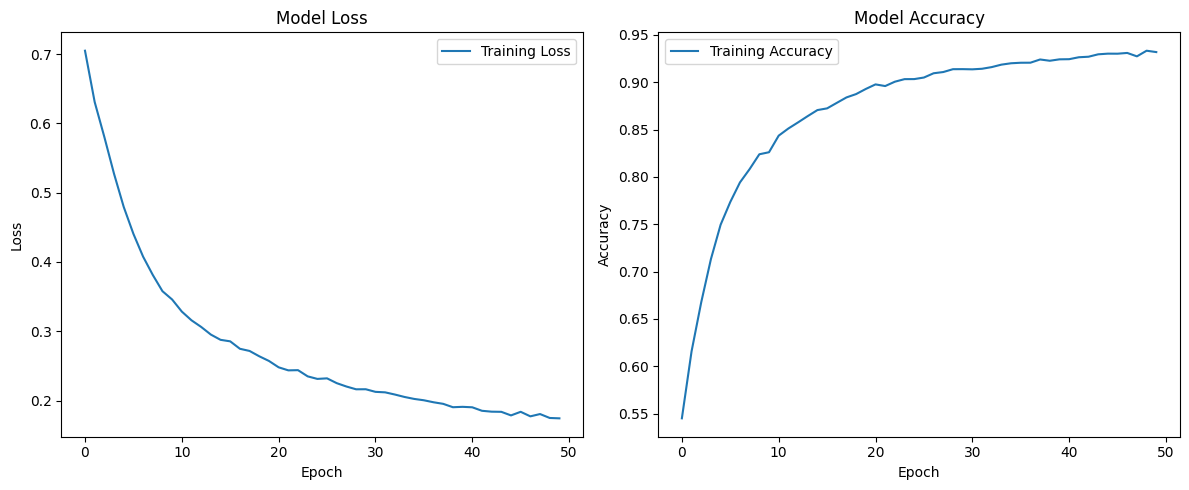

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()

In [ ]:
X_test_np = X_test.to_numpy()

X_test_reshaped = np.zeros((X_test_np.shape[0], 27, 13))

for i in range(27):
    X_test_reshaped[:, i, :] = X_test_np[:, i:i + 13]

test_loss, test_acc = model1.evaluate(X_test_reshaped, y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9337 - loss: 0.1556


In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# model1 = load_model('model1.keras')

# # Print the model summary to confirm successful loading
# model1.summary()

In [ ]:
X_test_reshaped.shape

(4998, 27, 13)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


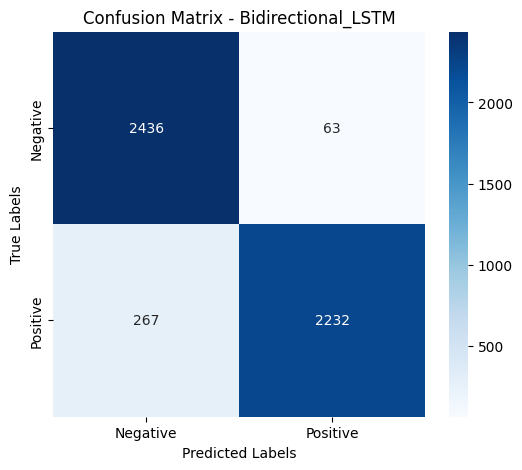

4998


In [ ]:
y_pred1 = (model1.predict(X_test_reshaped) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred1, "Bidirectional_LSTM")
print(len(X_test))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import numpy as np

# Evaluate the model on test data
loss, accuracy1 = model1.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Accuracy: {accuracy1:.4f}")

# Get model predictions (probabilities)
y_pred_probs = model1.predict(X_test_reshaped)

# Directly use predicted probabilities (avoid threshold)
y_pred = np.round(y_pred_probs)  # Instead of (y_pred_probs >= 0.5)

# Compute precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9337 - loss: 0.1556
Test Accuracy: 0.9340
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.94      2499
           1       0.97      0.89      0.93      2499

    accuracy                           0.93      4998
   macro avg       0.94      0.93      0.93      4998
weighted avg       0.94      0.93      0.93      4998

Precision: 0.9725
Recall: 0.8932


### Model 2: **WIREnet**

In [ ]:
X_train,X_Test,Y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True,random_state=42)
X_train.shape[1]
print(Y_train.value_counts(), y_test.value_counts())

LABEL
1    9994
0    9994
Name: count, dtype: int64 LABEL
0    2499
1    2499
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_Test)
X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

In [ ]:
def WIRENetSpoofImprovedEnhanced(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Conv1D(512, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    x = Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Conv1D(512, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model
input_shape = (X_train_std.shape[1], 1)
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.1
    return lr
model2 = WIRENetSpoofImprovedEnhanced(input_shape)
model2.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00003),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history2 = model2.fit(
    X_train_std,
    Y_train,
    epochs=50,
    batch_size=128,
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5752 - loss: 4.0995
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7669 - loss: 3.5654
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8435 - loss: 3.1758
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8824 - loss: 2.8639
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9020 - loss: 2.5809
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9205 - loss: 2.3266
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9312 - loss: 2.0982
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9413 - loss: 1.8821
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9507 - loss: 1.6859
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9541 - loss: 1.5106
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9612 - loss: 1.3423
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# model2 = load_model('model2.keras')

# # Print the model summary to confirm successful loading
# model2.summary()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import numpy as np

# Evaluate the model on test data
loss, accuracy2 = model2.evaluate(X_test_std, y_test, verbose=1)
print(f"Test Accuracy: {accuracy2:.4f}")

# Get model predictions (probabilities)
y_pred_probs = model2.predict(X_test_std)

# Use np.round() instead of a manual threshold
y_pred = np.round(y_pred_probs)  # Automatically rounds (0.49 → 0, 0.51 → 1)

# Compute precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9733 - loss: 0.1113
Test Accuracy: 0.9720
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2499
           1       0.97      0.97      0.97      2499

    accuracy                           0.97      4998
   macro avg       0.97      0.97      0.97      4998
weighted avg       0.97      0.97      0.97      4998

Precision: 0.9735
Recall: 0.9704


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


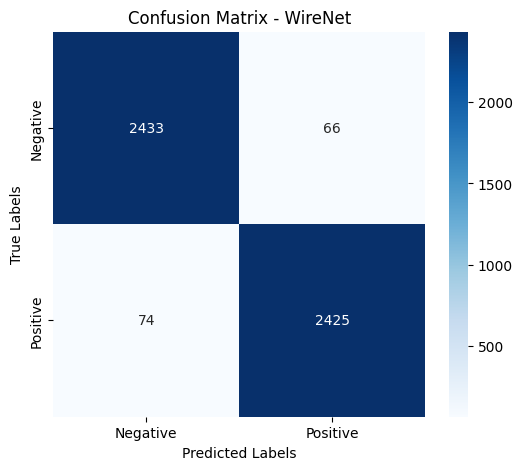

4998


In [ ]:
y_pred2 = (model2.predict(X_test_std) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred2, "WireNet")
print(len(X_test))

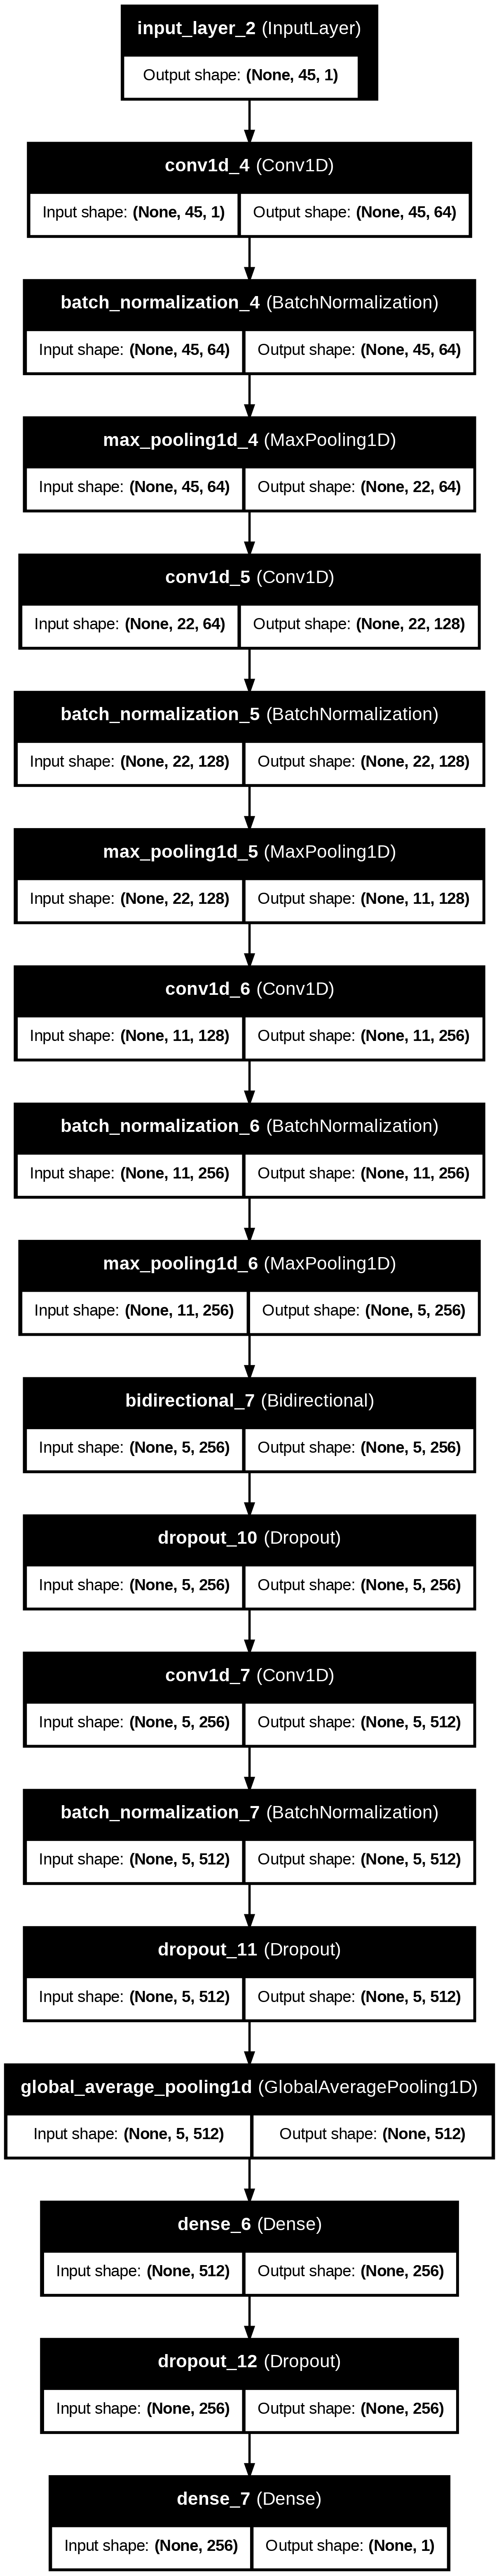

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='wirenet_architecture.png', show_shapes=True, show_layer_names=True)

### Model 3: **Random** **Forest** **Classifier**

In [ ]:
X_train,X_Test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True,random_state=42)
X_train.shape[1]
print(Y_train.value_counts(), y_test.value_counts())

LABEL
1    9994
0    9994
Name: count, dtype: int64 LABEL
0    2499
1    2499
Name: count, dtype: int64


In [ ]:
rf = RandomForestClassifier(
    n_estimators=72,
    max_depth=10,
    min_samples_split=11,
    min_samples_leaf=7,
    max_features='sqrt',
    random_state=42
)

history3 = rf.fit(X_train, y_train)


train_accuracy = rf.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9676


In [ ]:
y_pred = rf.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred)
print(accuracy3)

0.9321728691476591


In [ ]:
y_pred_new = rf.predict(X_test)

# Compute accuracy
accuracy3 = accuracy_score(y_test, y_pred_new)
precision = precision_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new)

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_new))

print(f"Test Accuracy: {accuracy3:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      2499
           1       0.97      0.89      0.93      2499

    accuracy                           0.93      4998
   macro avg       0.94      0.93      0.93      4998
weighted avg       0.94      0.93      0.93      4998

Test Accuracy: 0.9322
Precision: 0.9716
Recall: 0.8904


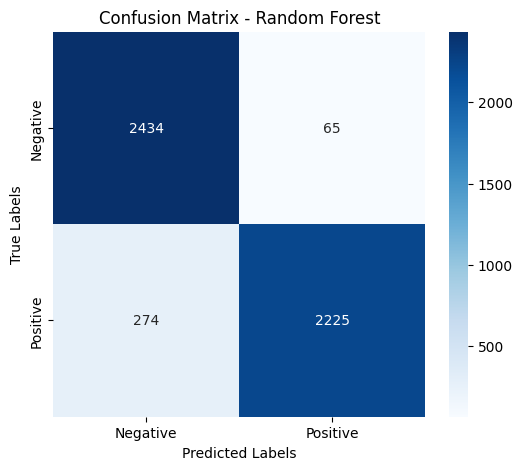

In [ ]:
# Get predictions for Random Forest
y_pred3 = rf.predict(X_test)  # No need for np.argmax()

# Ensure y_test is in the correct format (convert from one-hot if needed)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Plot Confusion Matrix for Random Forest
plot_confusion_matrix(y_test, y_pred3, "Random Forest")

In [ ]:
import pickle
import json

# Save Random Forest history (history3)
rf_metrics = {
    "train_accuracy": history3.score(X_train, y_train),
    "test_accuracy": history3.score(X_test, y_test)
}
with open("history3_rf.json", "w") as f:
    json.dump(rf_metrics, f)
print("History3 saved successfully!")

History3 saved successfully!


### Model 4: **SVM** (Support Vector Machine)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(len(X_train),len(X_test))
print(X_train[0])

19988 4998
[ 0.87463581 -0.70562287  0.60437216  0.99803475  1.0648542  -0.10089737
 -0.88777787  0.18106938  0.57777255  0.45576134  0.49668147  0.13518752
 -0.30776298  0.6466523   0.17156159  0.65920899  0.73906867  0.76406192
  0.27374678 -0.72117231  0.50808702 -0.49148421  0.10923498  0.71521541
  0.22290298  0.39606188 -0.13488443 -0.0106982  -0.75370302  0.467911
  0.23446693 -1.48538403 -0.27404709 -0.70284971 -0.95984141 -0.42067111
 -0.11676854 -0.00523758 -0.40369786 -0.37142829 -0.14747844 -0.79609247
 -0.00713462  1.26947495  0.77662864]


In [ ]:
svm_classifier = SVC(kernel='rbf', C=3.5,random_state=42)
history4 = svm_classifier.fit(X_train, y_train)

In [ ]:
y_train_pred = svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9912


In [ ]:
y_pred = svm_classifier.predict(X_test)
accuracy4 = accuracy_score(y_test, y_pred)
print(accuracy4)

0.9853941576630653


In [ ]:
y_pred_new = svm_classifier.predict(X_test)

# Compute accuracy, precision, and recall
accuracy4 = accuracy_score(y_test, y_pred_new)
precision = precision_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new)

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_new))

print(f"Test Accuracy: {accuracy4:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2499
           1       0.99      0.98      0.99      2499

    accuracy                           0.99      4998
   macro avg       0.99      0.99      0.99      4998
weighted avg       0.99      0.99      0.99      4998

Test Accuracy: 0.9854
Precision: 0.9891
Recall: 0.9816


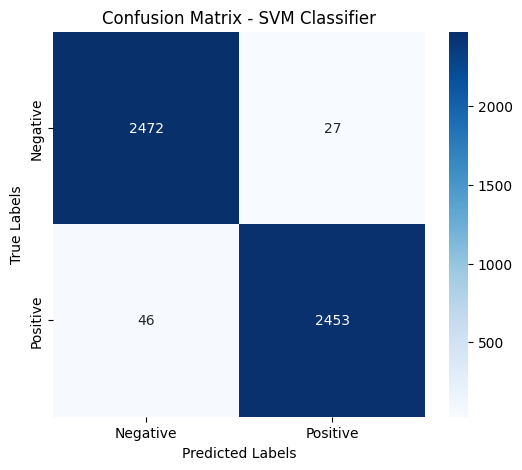

In [ ]:
# Get predictions for SVM Classifier
y_pred_svm = svm_classifier.predict(X_test)  # No need for np.argmax()

# Ensure y_test is in the correct format (convert from one-hot if needed)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Plot Confusion Matrix for SVM Classifier
plot_confusion_matrix(y_test, y_pred_svm, "SVM Classifier")

In [ ]:
import pickle
import json

# Save SVM history (history4)
svm_metrics = {
    "train_accuracy": history4.score(X_train, y_train),
    "test_accuracy": history4.score(X_test, y_test)
}
with open("history4_svm.json", "w") as f:
    json.dump(svm_metrics, f)

print("History4 saved successfully!")


History4 saved successfully!


### Model 5: **ResNet** **FC**

In [ ]:
n_samples = min(len(real_df), len(fake_df))

real_df_downsampled = real_df.sample(n=n_samples, random_state=42)
fake_df_downsampled = fake_df.sample(n=n_samples, random_state=42)

balanced_audio_data = pd.concat([real_df_downsampled, fake_df_downsampled]).sample(frac=1, random_state=42)

X = balanced_audio_data.drop(columns=['LABEL'])
y = balanced_audio_data['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, shuffle=True, random_state=42)
print(len(X_test),len(X_train))

4998 19988


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def res_block(x, units):
    """Residual block for fully connected layers."""
    res = layers.Dense(units, activation='relu')(x)
    res = layers.BatchNormalization()(res)
    res = layers.Dense(units)(res)
    res = layers.BatchNormalization()(res)
    x = layers.Add()([x, res])
    return layers.ReLU()(x)

def ResNetFC(input_shape, num_classes=1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 128)
    x = res_block(x, 128)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

input_shape = (X_train.shape[1],)  # Ensure input shape matches feature count
model5 = ResNetFC(input_shape)

# Compile model
model5.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00003),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history5 = model5.fit(X_train, y_train, epochs=50, batch_size=128)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5315 - loss: 0.7738
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7865 - loss: 0.4677
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8595 - loss: 0.3633
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8900 - loss: 0.3002
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9057 - loss: 0.2626
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.2400
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9192 - loss: 0.2175
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9256 - loss: 0.2007
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9351 - loss: 0.1828
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9374 - loss: 0.1745
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9406 - loss: 0.1604
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# model5 = load_model('model5.keras')

# # Print the model summary to confirm successful loading
# model5.summary()

In [ ]:
# Evaluate model
accuracy5 = model5.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy5[1] * 100:.2f}%')

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9766 - loss: 0.0646
Test Accuracy: 97.46%


In [ ]:
print(len(X_test),len(X_train),len(y_test))

4998 19988 4998


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


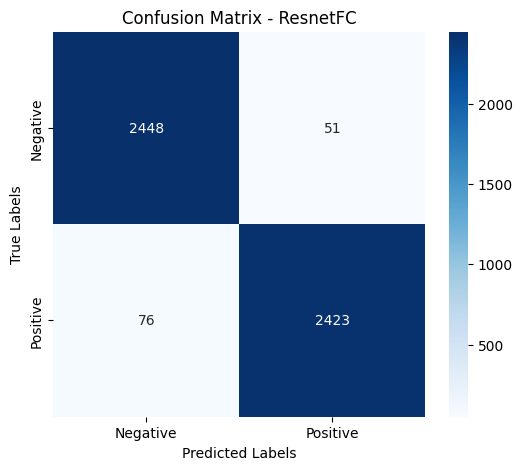

4998


In [ ]:
y_pred5 = (model5.predict(X_test) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred5, "ResnetFC")
print(len(X_test))

In [ ]:
# Predict using trained ResNetFC model
y_pred_probs = model5.predict(X_test)  # Probabilities from sigmoid layer
y_pred_new = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels

# Compute accuracy, precision, and recall
accuracy5 = accuracy_score(y_test, y_pred_new)
precision = precision_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new)

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_new))

print(f"Test Accuracy: {accuracy5:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2499
           1       0.98      0.97      0.97      2499

    accuracy                           0.97      4998
   macro avg       0.97      0.97      0.97      4998
weighted avg       0.97      0.97      0.97      4998

Test Accuracy: 0.9746
Precision: 0.9794
Recall: 0.9696


### Model 6: **SE**-**Enhanced** **1D**-**CNN** **for** **Time** **Series** **Classification**

In [ ]:
n_samples = min(len(real_df), len(fake_df))

real_df_downsampled = real_df.sample(n=n_samples, random_state=42)
fake_df_downsampled = fake_df.sample(n=n_samples, random_state=42)

balanced_audio_data = pd.concat([real_df_downsampled, fake_df_downsampled]).sample(frac=1, random_state=42)

X = balanced_audio_data.drop(columns=['LABEL'])
y = balanced_audio_data['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, shuffle=True, random_state=42)
print(len(X_test),len(X_train))

4998 19988


In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Flatten,
                                     Dense, Add, GlobalAveragePooling2D, Reshape, Dropout, Multiply)
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE  # New: Synthetic Oversampling
from tensorflow.keras.optimizers.schedules import CosineDecay  # New: Better LR Scheduler

# Load and encode primary dataset
df = pd.read_csv(data_file)
label_encoder = LabelEncoder()
df['LABEL'] = label_encoder.fit_transform(df['LABEL'])

real_df = df[df['LABEL'] == 1]
fake_df = df[df['LABEL'] == 0]

n_samples = min(len(real_df), len(fake_df))

real_df_downsampled = real_df.sample(n=n_samples, random_state=42)
fake_df_downsampled = fake_df.sample(n=n_samples, random_state=42)

balanced_audio_data = pd.concat([real_df_downsampled, fake_df_downsampled]).sample(frac=1, random_state=42)

X = balanced_audio_data.drop(columns=['LABEL'])
y = balanced_audio_data['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, shuffle=True, random_state=42)
# # Select features & labels
# feature_columns = df.columns[:-1]
# X = df[feature_columns].values
# y = df["LABEL"].values

# # Apply SMOTE for better class balance
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into train, validation, and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape for CNN input (Batch, Time, Features)
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7bd098b5d580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


In [ ]:
X_test_reshaped.shape

(4998, 1, 45)

In [ ]:
# Define custom Focal Loss to handle class imbalance
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = 1e-6
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * (1 - pt) ** gamma * tf.math.log(pt)
        return tf.reduce_sum(loss, axis=-1)
    return loss

# Define Cosine Learning Rate Scheduler
# initial_learning_rate = 0.005
# lr_schedule = CosineDecay(initial_learning_rate, decay_steps=1000, alpha=0.0001)

# Number of features
num_features = X_train_reshaped.shape[-1]

# Define Model Architecture with Residual Connections
input_layer = Input(shape=(1, num_features, 1))  # (Time, Features, Channel)

# Conv Block 1
x = Conv2D(64, (1, 3), padding="same", kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(1, 2))(x)
x = Dropout(0.3)(x)

# Residual Block 1
res = Conv2D(64, (1, 3), padding="same", kernel_regularizer=l2(0.001))(x)
res = BatchNormalization()(res)
res = LeakyReLU()(res)
res = Conv2D(64, (1, 3), padding="same", kernel_regularizer=l2(0.001))(res)
res = BatchNormalization()(res)
x = Add()([x, res])  # Residual Connection
x = LeakyReLU()(x)

# Conv Block 2
x = Conv2D(128, (1, 3), padding="same", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(1, 2))(x)
x = Dropout(0.3)(x)

# Squeeze-and-Excitation (SE) Attention
se = GlobalAveragePooling2D()(x)
se = Dense(64, activation="relu")(se)
se = Dense(128, activation="sigmoid")(se)
se = Reshape((1, 1, 128))(se)
x = Multiply()([x, se])

# Fully Connected Layers
x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(y_train_categorical.shape[1], activation="softmax")(x)

# Build Model
model6 = Model(inputs=input_layer, outputs=output_layer)

# Compile Model with Focal Loss
model6.compile(loss=focal_loss(), optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00003), metrics=["accuracy"])
model6.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1, 45, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1, 45, 64)      │            256 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 1, 45, 64)      │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 1, 45, 64)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 1, 22, 64)      │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 1, 22, 64)      │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1, 22, 64)      │         12,352 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 1, 22, 64)      │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 1, 22, 64)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 1, 22, 64)      │         12,352 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 1, 22, 64)      │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 22, 64)      │              0 │ dropout_13[0][0],      │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 1, 22, 64)      │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 1, 22, 128)     │         24,704 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 1, 22, 128)     │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 1, 22, 128)     │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 256,258 (1001.01 KB)

 Trainable params: 255,618 (998.51 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

# Train Model
history6 = model6.fit(
    X_train_reshaped, y_train_categorical,
    epochs=50,
    batch_size=64,
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5549 - loss: 0.6844
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6719 - loss: 0.6027
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7348 - loss: 0.5739
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7868 - loss: 0.5491
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8161 - loss: 0.5247
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8322 - loss: 0.5017
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8422 - loss: 0.4801
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8564 - loss: 0.4574
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8630 - loss: 0.4352
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8692 - loss: 0.4133
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8760 - loss: 0.3913
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/st

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Multiply
from tensorflow.keras.optimizers.schedules import CosineDecay

# Define Custom Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = 1e-6
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * (1 - pt) ** gamma * tf.math.log(pt)
        return tf.reduce_sum(loss, axis=-1)  # Match the function definition used in training
    return loss

# # Load the saved model
# model6 = tf.keras.models.load_model("model6.keras", custom_objects={"loss": focal_loss()})

# Verify model architecture
model6.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1, 45, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1, 45, 64)      │            256 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 1, 45, 64)      │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 1, 45, 64)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 1, 22, 64)      │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 1, 22, 64)      │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1, 22, 64)      │         12,352 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 1, 22, 64)      │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 1, 22, 64)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 1, 22, 64)      │         12,352 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 1, 22, 64)      │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 22, 64)      │              0 │ dropout_13[0][0],      │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 1, 22, 64)      │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 1, 22, 128)     │         24,704 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 1, 22, 128)     │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 1, 22, 128)     │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 767,496 (2.93 MB)

 Trainable params: 255,618 (998.51 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 511,238 (1.95 MB)

In [ ]:
# Generate classification reports
y_test_pred = np.argmax(model6.predict(X_test_reshaped), axis=1)
accuracy6 = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy6:.4f}")
unique_labels = np.unique(np.concatenate((y_test, y_test_pred)))
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, labels=unique_labels))

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test Accuracy: 0.9764
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2499
           1       0.98      0.97      0.98      2499

    accuracy                           0.98      4998
   macro avg       0.98      0.98      0.98      4998
weighted avg       0.98      0.98      0.98      4998



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


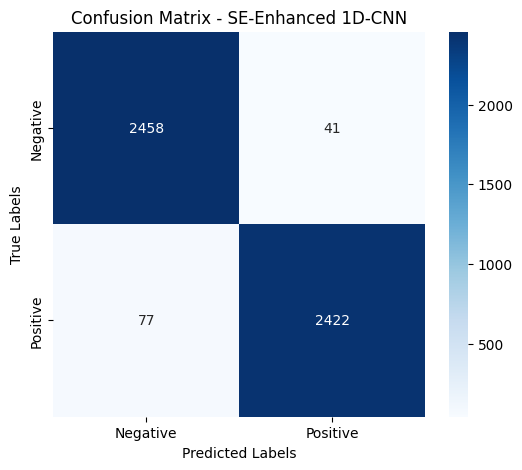

In [ ]:
# Model 6 SE-Enhanced 1D-CNN for Time Series Classification
y_pred6 = np.argmax(model6.predict(X_test_reshaped), axis=1)
plot_confusion_matrix(y_test, y_pred6, "SE-Enhanced 1D-CNN")

In [ ]:
audio_data = pd.read_csv(data_file)

label_encoder = LabelEncoder()
audio_data['LABEL'] = label_encoder.fit_transform(audio_data['LABEL'])

y = audio_data['LABEL']
X = audio_data.drop('LABEL', axis = 1)

real_df = audio_data[audio_data['LABEL'] == 1]
fake_df = audio_data[audio_data['LABEL'] == 0]

fake_df_downsampled = fake_df.sample(n=len(real_df), random_state=42)

balanced_audio_data = pd.concat([real_df, fake_df_downsampled]).sample(frac=1, random_state=42)

X = balanced_audio_data.drop(columns=['LABEL'])
y = balanced_audio_data['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(y_train.value_counts(), y_test.value_counts())

LABEL
0    10020
1     9968
Name: count, dtype: int64 LABEL
1    2525
0    2473
Name: count, dtype: int64


In [ ]:
print("X_train shape:", X_train.shape)  # (samples, 1, 26, 10)
print("y_train shape:", y_train.shape)  # (samples,)

X_train shape: (19988, 45)
y_train shape: (19988,)


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Convert pandas DataFrame to NumPy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Ensure labels are one-hot encoded
NUM_CLASSES = len(np.unique(y_train))  # Get the number of unique classes
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# Reshape X_train for CNN input
# Assuming you want a 2D (image-like) representation, reshape to (15,3,1)
X_train = X_train.reshape((X_train.shape[0], 15, 3, 1))
X_test = X_test.reshape((X_test.shape[0], 15, 3, 1))

# Define the CNN input shape
input_shape = (15, 3, 1)

print("X_train shape:", X_train.shape)  # Should be (num_samples, 13, 2, 1)
print("y_train shape:", y_train.shape)  # Should be (num_samples, NUM_CLASSES)

X_train shape: (19988, 15, 3, 1)
y_train shape: (19988, 2)


### Model 7: **Custom** **CNN**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical

# Define input shape
input_shape = (15, 3, 1)  # (Height=13, Width=2, Channels=1)

# Input layer
model_input = Input(shape=input_shape)

# First Conv layer with L2 regularization
x = Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.004))(model_input)
x = MaxPooling2D(pool_size=(2, 1), padding='same')(x)  # Pool over height only

# Second Conv layer with L2 regularization
x = Conv2D(64, kernel_size=(2, 1), activation='relu', padding='same', kernel_regularizer=l2(0.004))(x)
x = MaxPooling2D(pool_size=(2, 1), padding='same')(x)

# Flatten and Dense layers with L2 regularization
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.004))(x)
x = Dropout(0.5)(x)  # Dropout for regularization

# Output layer
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

# # Define learning rate schedule
# lr_schedule = ExponentialDecay(initial_learning_rate=0.00001, decay_steps=1000, decay_rate=0.96, staircase=True)

# Define and compile model
model7 = Model(inputs=model_input, outputs=model_output)
model7.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00003), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model7.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 15, 3, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 15, 3, 32)           │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 3, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,010 (402.38 KB)

 Trainable params: 103,010 (402.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history7 = model7.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.6676 - loss: 1.5955 - val_accuracy: 0.8261 - val_loss: 1.2058
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8302 - loss: 1.1422 - val_accuracy: 0.8627 - val_loss: 0.9511
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8628 - loss: 0.9196 - val_accuracy: 0.8743 - val_loss: 0.8165
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8662 - loss: 0.8095 - val_accuracy: 0.8758 - val_loss: 0.7337
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8688 - loss: 0.7330 - val_accuracy: 0.8830 - val_loss: 0.6719
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8790 - loss: 0.6702 - val_accuracy: 0.8872 - val_loss: 0.6256
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8827 - loss: 0.6264 - val_accuracy: 0.8882 - val_loss: 0.5896
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8885 - loss: 0.5908 - val_accuracy:

In [ ]:
# model7 = tf.keras.models.load_model("model7.keras")
model7.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 15, 3, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 15, 3, 32)           │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 3, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 309,032 (1.18 MB)

 Trainable params: 103,010 (402.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,022 (804.78 KB)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Predict class probabilities
y_pred_probs = model7.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy7 = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy7:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Model Accuracy: 0.9526
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2473
           1       0.96      0.94      0.95      2525

    accuracy                           0.95      4998
   macro avg       0.95      0.95      0.95      4998
weighted avg       0.95      0.95      0.95      4998



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


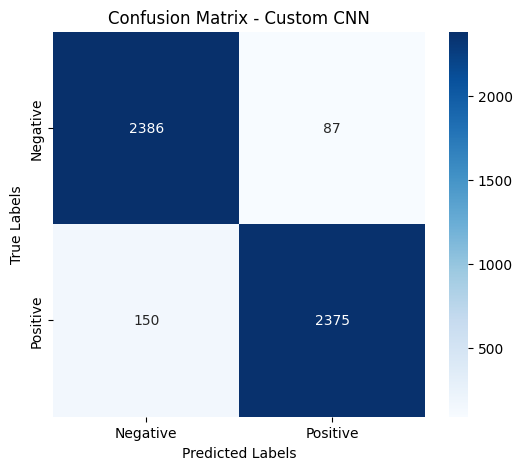

In [ ]:
# Convert one-hot encoded y_test to class labels
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check if y_test is one-hot
    y_test = np.argmax(y_test, axis=1)

# Get predictions for Custom CNN (Model 7)
y_pred7 = np.argmax(model7.predict(X_test), axis=1)  # Convert probabilities to class labels

# Plot Confusion Matrix for Custom CNN
plot_confusion_matrix(y_test, y_pred7, "Custom CNN")


### Model 8: **ResCNN**-**Attention**-**BiGRU**

In [ ]:
audio_data = pd.read_csv(data_file)

label_encoder = LabelEncoder()
audio_data['LABEL'] = label_encoder.fit_transform(audio_data['LABEL'])

y = audio_data['LABEL']
X = audio_data.drop('LABEL', axis = 1)

real_df = audio_data[audio_data['LABEL'] == 1]
fake_df = audio_data[audio_data['LABEL'] == 0]

fake_df_downsampled = fake_df.sample(n=len(real_df), random_state=42)

balanced_audio_data = pd.concat([real_df, fake_df_downsampled]).sample(frac=1, random_state=42)

X = balanced_audio_data.drop(columns=['LABEL'])
y = balanced_audio_data['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(y_train.value_counts(), y_test.value_counts())

LABEL
0    10020
1     9968
Name: count, dtype: int64 LABEL
1    2525
0    2473
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load Dataset
df = pd.read_csv(data_file)

# Encode Labels
label_encoder = LabelEncoder()
df["LABEL"] = label_encoder.fit_transform(df["LABEL"])

# Downsample Fake Data to Match Real Data
real_df = df[df["LABEL"] == 1]
fake_df = df[df["LABEL"] == 0]
fake_df_downsampled = fake_df.sample(n=len(real_df), random_state=42)

# Combine and Shuffle Balanced Dataset
balanced_df = pd.concat([real_df, fake_df_downsampled]).sample(frac=1, random_state=42)

# Extract Features & Labels
X = balanced_df.drop(columns=["LABEL"]).values
y = balanced_df["LABEL"].values

# Normalize Features (Zero Mean, Unit Variance)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# Reshape for Conv1D (Batch, Time, Features)
X_train_reshaped = np.expand_dims(X_train, axis=-1)  # (Batch, Time_Steps, Features)
X_test_reshaped = np.expand_dims(X_test, axis=-1)

# Convert Labels to One-Hot Encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

print("Final Data Shapes:")
print(f"X_train: {X_train_reshaped.shape}, y_train: {y_train_categorical.shape}")
print(f"X_test: {X_test_reshaped.shape}, y_test: {y_test_categorical.shape}")


Final Data Shapes:
X_train: (19988, 45, 1), y_train: (19988, 2)
X_test: (4998, 45, 1), y_test: (4998, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation, Dropout, Dense,
                                     Add, GlobalAveragePooling1D, Multiply, GRU, Bidirectional)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np

# Define Custom Focal Loss for Imbalanced Data
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = 1e-6
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * (1 - pt) ** gamma * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return loss

# Self-Attention Mechanism (for sequence learning)
def self_attention(x):
    attn_weights = Dense(x.shape[-1], activation="softmax")(x)
    return Multiply()([x, attn_weights])

# Learning Rate Warmup + Cosine Decay
def warmup_cosine_decay(lr_start=1e-4, lr_max=0.005, warmup_epochs=5, total_epochs=50):
    def scheduler(epoch):
        if epoch < warmup_epochs:
            return lr_start + (lr_max - lr_start) * (epoch / warmup_epochs)
        else:
            return lr_max * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    return tf.keras.callbacks.LearningRateScheduler(scheduler)

# Input Shape
num_features = X_train_reshaped.shape[1]  # Number of Time Steps (e.g., MFCCs)
num_channels = X_train_reshaped.shape[-1]  # 1 for mono audio features

input_layer = Input(shape=(num_features, num_channels))  # (Time, Features)

# Conv Block 1 (Feature Extraction)
x = Conv1D(64, kernel_size=5, strides=1, padding="same", kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = Activation("swish")(x)
x = Dropout(0.3)(x)

# Residual Block 1
res = Conv1D(64, kernel_size=5, padding="same", kernel_regularizer=l2(0.001))(x)
res = BatchNormalization()(res)
res = Activation("swish")(res)
res = Conv1D(64, kernel_size=5, padding="same", kernel_regularizer=l2(0.001))(res)
res = BatchNormalization()(res)
x = Add()([x, res])  # Residual Connection
x = Activation("swish")(x)

# Conv Block 2 (Higher-level Features)
x = Conv1D(128, kernel_size=5, strides=2, padding="same", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation("swish")(x)
x = Dropout(0.3)(x)

# Self-Attention for Feature Enhancement
x = self_attention(x)

# BiGRU Layer (Sequence Learning)
x = Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)

# Global Feature Pooling
x = GlobalAveragePooling1D()(x)

# Fully Connected Layers
x = Dense(128, activation="swish", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="swish", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(y_train_categorical.shape[1], activation="softmax")(x)

# Build Model
model8 = Model(inputs=input_layer, outputs=output_layer)

# Compile Model with Focal Loss
model8.compile(loss=focal_loss(), optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00003), metrics=["accuracy"])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
lr_scheduler = warmup_cosine_decay()

# Train Model
history8 = model8.fit(
    X_train_reshaped, y_train_categorical,
    validation_data=(X_test_reshaped, y_test_categorical),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.5126 - loss: 0.4282 - val_accuracy: 0.5052 - val_loss: 0.3246 - learning_rate: 1.0000e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.6928 - loss: 0.1720 - val_accuracy: 0.5324 - val_loss: 0.0570 - learning_rate: 0.0011
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.7881 - loss: 0.0419 - val_accuracy: 0.7849 - val_loss: 0.0536 - learning_rate: 0.0021
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.8066 - loss: 0.0437 - val_accuracy: 0.8077 - val_loss: 0.0362 - learning_rate: 0.0030
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.8106 - loss: 0.0386 - val_accuracy: 0.7825 - val_loss: 0.0457 - learning_rate: 0.0040
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.7989 - loss: 0.0449 - val_accuracy: 0.7909 - val_loss: 0.0354 - learning_rate: 0.0050
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy:

In [ ]:
# model8 = tf.keras.models.load_model("model8.keras", custom_objects={"loss": focal_loss()})
model8.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 45, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 45, 64)         │            384 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 45, 64)         │            256 │ conv1d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 45, 64)         │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 45, 64)         │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 45, 64)         │         20,544 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 45, 64)         │            256 │ conv1d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 45, 64)         │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 45, 64)         │         20,544 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 45, 64)         │            256 │ conv1d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 45, 64)         │              0 │ dropout_18[0][0],      │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 45, 64)         │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 23, 128)        │         41,088 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 23, 128)        │            512 │ conv1d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 23, 128)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 23, 128)        │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)     

 Total params: 597,960 (2.28 MB)

 Trainable params: 199,106 (777.76 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 398,214 (1.52 MB)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict class probabilities
y_pred_probs = model8.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred_labels = y_pred_probs.argmax(axis=1)
y_true_labels = y_test_categorical.argmax(axis=1)  # Convert one-hot to class labels

# Compute overall precision, recall, and F1-score
precision = precision_score(y_true_labels, y_pred_labels)
recall = recall_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
Precision: 0.9594
Recall: 0.9537
F1 Score: 0.9565


In [ ]:
# Evaluate the model on the test set
test_loss, accuracy8 = model8.evaluate(X_test_reshaped, y_test_categorical, verbose=1)

# Print accuracy
print(f"Test Accuracy: {accuracy8 * 100:.2f}%")

# Generate predictions
y_pred = model8.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)  # Convert one-hot labels to class labels

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes))

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9556 - loss: 0.0089
Test Accuracy: 95.62%
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      2473
           1       0.96      0.95      0.96      2525

    accuracy                           0.96      4998
   macro avg       0.96      0.96      0.96      4998
weighted avg       0.96      0.96      0.96      4998



157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step


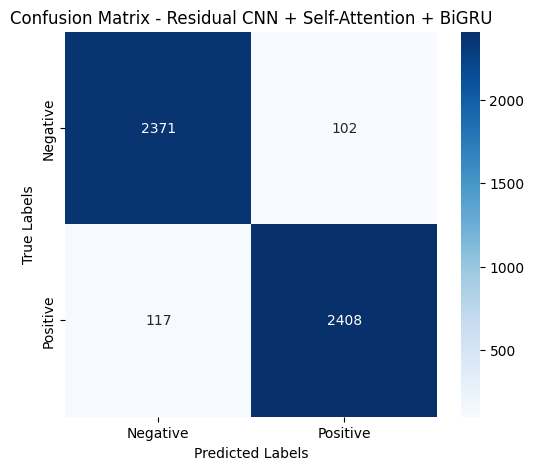

In [ ]:
# Get predictions for ResCNN-Attn-BiGRU
y_pred8 = np.argmax(model8.predict(X_test_reshaped), axis=1)  # Convert probabilities to class labels

# Plot Confusion Matrix for ResCNN-Attn-BiGRU
plot_confusion_matrix(y_test, y_pred8, "Residual CNN + Self-Attention + BiGRU")

In [ ]:
import tensorflow as tf

# Dictionary of model names and objects
models = {
    "model1": model1,
    "model2": model2,
    "model5": model5,
    "model6": model6,
    "model7": model7
}

# Save each model using its actual name
for name, model in models.items():
    model.save(f"{name}.keras")  # Save using Keras format
    print(f"{name} saved as {name}.keras")

model1 saved as model1.keras
model2 saved as model2.keras
model5 saved as model5.keras
model6 saved as model6.keras
model7 saved as model7.keras


In [ ]:
model8.save("model8.keras")

In [ ]:
import joblib

# Save Random Forest model
joblib.dump(rf, 'random_forest_model.pkl')
print("Random Forest model saved as random_forest_model.pkl")

# Save SVM model
joblib.dump(svm_classifier, 'svm_model.pkl')
print("SVM model saved as svm_model.pkl")

Random Forest model saved as random_forest_model.pkl
SVM model saved as svm_model.pkl


In [ ]:
import pickle
import json

# Save Keras model histories (history1, history2, history5, history6, history7)
for i in [1, 2,5 ,6 ,7, 8]:
    with open(f"history{i}.json", "w") as f:
        json.dump(eval(f"history{i}.history"), f)
print("All histories 1, 2, 5, 6, 7, 8 saved successfully!")

All histories 1, 2, 5, 6, 7, 8 saved successfully!


In [ ]:
import json

# Function to load history from a JSON file
def load_history(file_name):
    with open(file_name, "r") as f:
        history = json.load(f)
    return history

# Load histories
history1 = load_history("history1.json")
history2 = load_history("history2.json")
history5 = load_history("history5.json")
history6 = load_history("history6.json")
history7 = load_history("history7.json")
history8 = load_history("history8.json")

# Print keys to check the loaded data
print(history1.keys())

dict_keys(['accuracy', 'loss'])


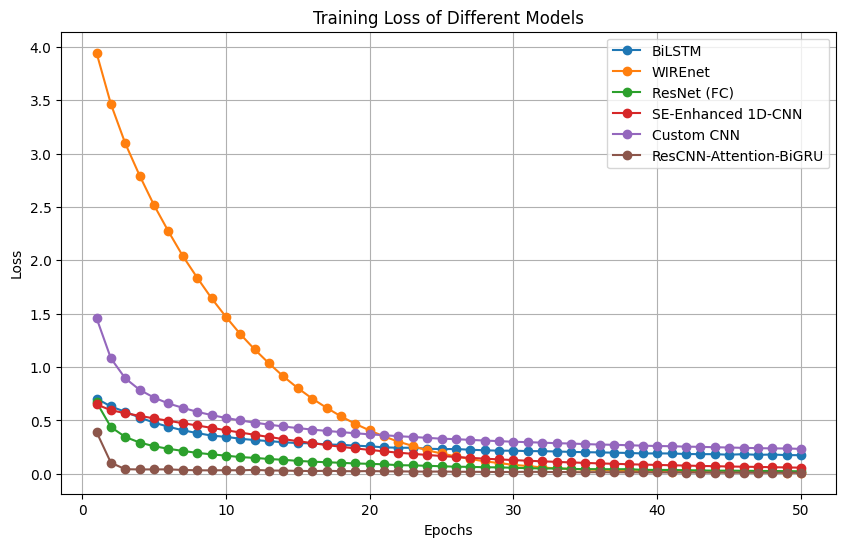

In [ ]:
# Extract loss values correctly
models_loss = {
    "BiLSTM": history1['loss'],
    "WIREnet": history2['loss'],
    "ResNet (FC)": history5['loss'],
    "SE-Enhanced 1D-CNN": history6['loss'],
    "Custom CNN": history7['loss'],
    "ResCNN-Attention-BiGRU": history8['loss']
}

epochs = range(1, len(next(iter(models_loss.values()))) + 1)  # Get number of epochs

plt.figure(figsize=(10, 6))

for model_name, loss in models_loss.items():
    plt.plot(epochs, loss, marker='o', label=model_name)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss of Different Models")
plt.legend()
plt.grid()
plt.show()


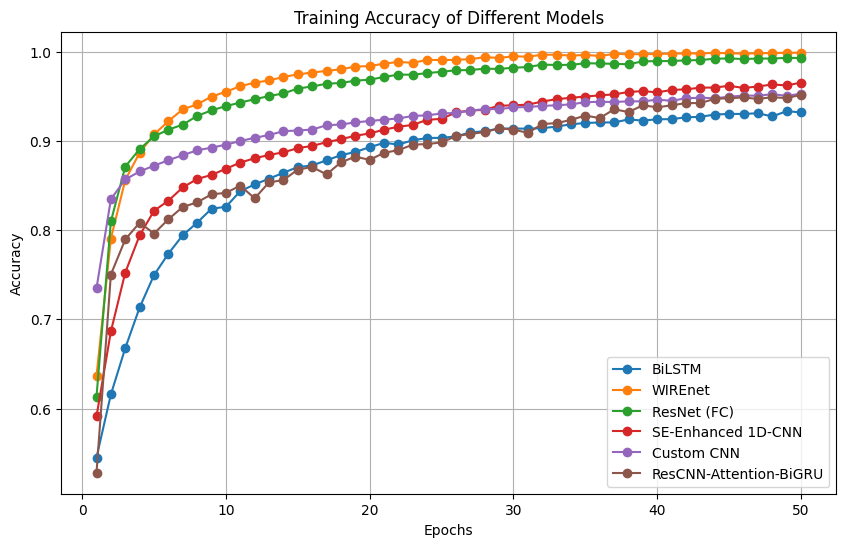

In [ ]:
# Extract accuracy values correctly
models_accuracy = {
    "BiLSTM": history1['accuracy'],
    "WIREnet": history2['accuracy'],
    "ResNet (FC)": history5['accuracy'],
    "SE-Enhanced 1D-CNN": history6['accuracy'],
    "Custom CNN": history7['accuracy'],
    "ResCNN-Attention-BiGRU": history8['accuracy']
}

epochs = range(1, len(next(iter(models_accuracy.values()))) + 1)  # Get number of epochs

plt.figure(figsize=(10, 6))

for model_name, acc in models_accuracy.items():
    plt.plot(epochs, acc, marker='o', label=model_name)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy of Different Models")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract training accuracies from history objects (Keras models)
model_names = ["BiLSTM", "WireNet", "ResnetFC", "SE-Enhanced 1D-CNN", "Custom CNN", "ResCNN-Attention-BiGRU"]
train_accuracies = [
    max(history1['accuracy']),
    max(history2['accuracy']),
    max(history5['accuracy']),
    max(history6['accuracy']),
    max(history7['accuracy']),
    max(history8['accuracy'])
]

In [ ]:
!pip install adjustText

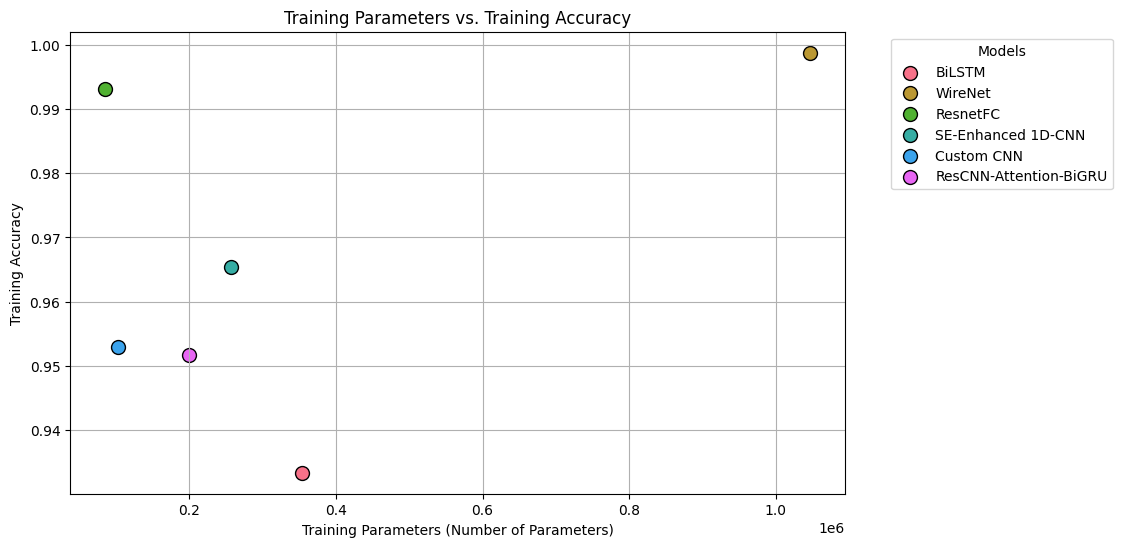

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

# Ensure the models are trained before extracting these values
parameters = [
    model1.count_params(),
    model2.count_params(),
    model5.count_params(),
    model6.count_params(),
    model7.count_params(),
    model8.count_params()
]

colors = sns.color_palette("husl", len(model_names))  # Generate unique colors for each model

# Set figure
plt.figure(figsize=(10, 6))

# Plot each model with a different color
for i, model in enumerate(model_names):
    plt.scatter(parameters[i], train_accuracies[i], color=colors[i], s=100, edgecolor='black', label=model)

# Labels & Title
plt.xlabel("Training Parameters (Number of Parameters)")
plt.ylabel("Training Accuracy")
plt.title("Training Parameters vs. Training Accuracy")

# Add legend
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()

In [ ]:
# Extract training accuracies
accuracies2 = [
    accuracy1,
    accuracy2,
    accuracy5,
    accuracy6,
    accuracy7,
    accuracy8
]

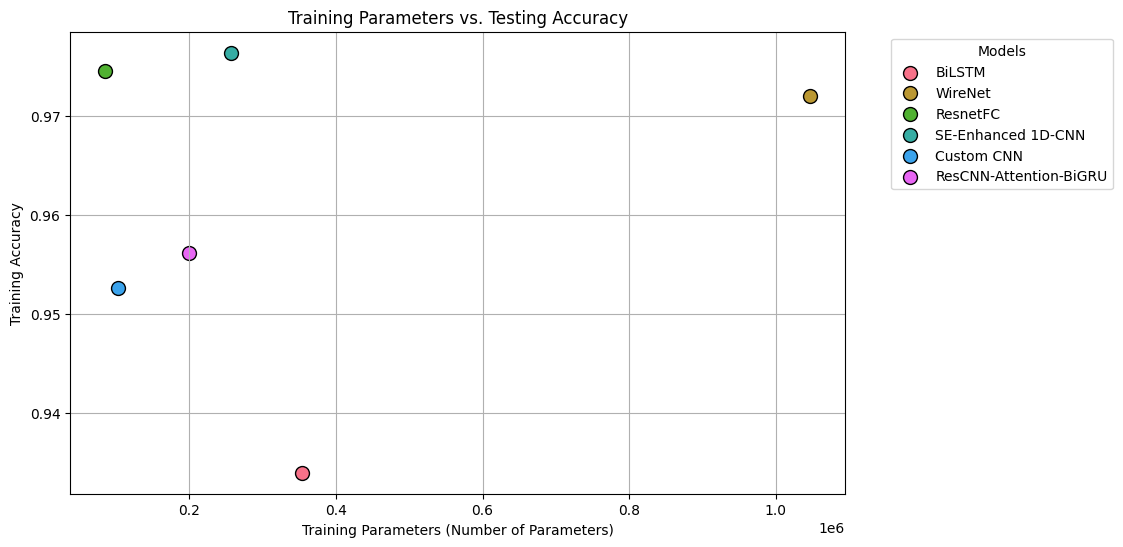

In [ ]:
colors = sns.color_palette("husl", len(model_names))

# Set figure
plt.figure(figsize=(10, 6))

# Plot each model with a different color
for i, model in enumerate(model_names):
    plt.scatter(parameters[i], accuracies2[i], color=colors[i], s=100, edgecolor='black', label=model)

# Labels & Title
plt.xlabel("Training Parameters (Number of Parameters)")
plt.ylabel("Training Accuracy")
plt.title("Training Parameters vs. Testing Accuracy")

# Add legend
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()

<ipython-input-131-7c93c1d7f031>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=parameters, palette="husl")


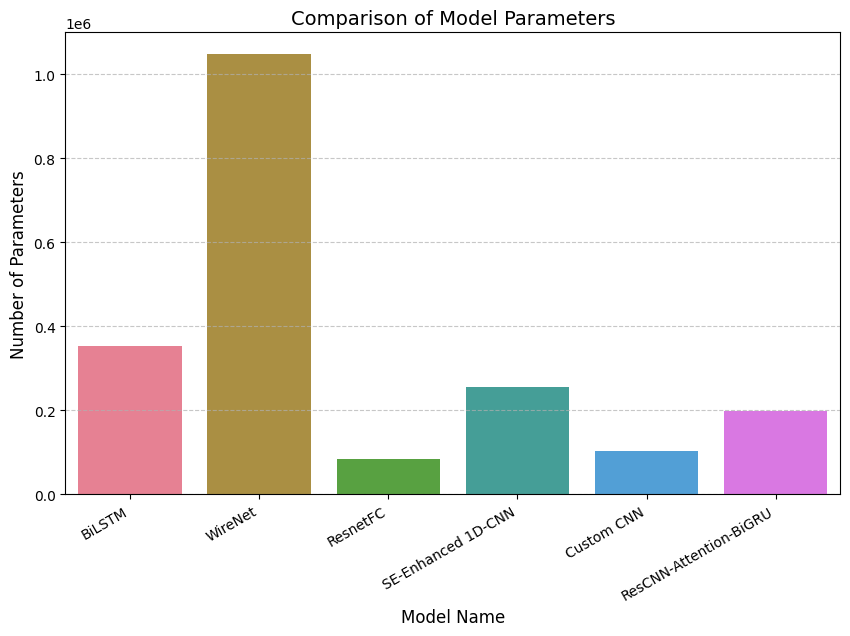

In [ ]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=parameters, palette="husl")

# Labels and title
plt.xlabel("Model Name", fontsize=12)
plt.ylabel("Number of Parameters", fontsize=12)
plt.title("Comparison of Model Parameters", fontsize=14)
plt.xticks(rotation=30, ha='right')  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()